## Import Statements

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
from scipy.stats import chi2
from IPython.display import clear_output 
from IPython.display import Image
import os
from os import path
import pandas as pd
from scipy.signal import find_peaks
import glob
import math

## Functions

In [4]:
def fits_data_to_3d_array(file_list): 
    '''
    Takes in a list of fits files and converts data into a 3d array
    Parameters:
        file_list (list): List containing paths of FITS files to convert.
    Returns:
        final_array: 3d array of data from each fits file.
    '''    
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#Creates a median combine of a 3d array
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
 
def save_array_to_fits_file(array, new_file_name):
    '''
    Saves a 2d array of pixel data to a FITS file.
    Parameters:
    array(2d): 2d array containing pixel values.
    new_file_name (path): location, name of FITS file to be saved.
    '''  
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name,overwrite=True)


def glob_files(folder, specifier, asterisks='both', show=False):
    asterisk = "*"
    if asterisks == 'both':
        files = glob.glob(os.path.join(folder, asterisk + specifier + asterisk))
    elif asterisks == 'left':
        files = glob.glob(os.path.join(folder, asterisk + specifier))
    elif asterisks == 'right':
        files = glob.glob(os.path.join(folder, specifier + asterisk))
    if show:
        print(f'Number of Files: {len(files)}')
        for file in files: 
            print(file)
    return files

def cut_pixel_data_array(pixel_data_array, y_pixel_min, y_pixel_max, print_shape=False):
    '''
    Returns an array of pixel data, cut to a specified vertical (y-pixel) range.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to create a cut from.
        y_pixel_min (int): Lower bound to start cut. 
        y_pixel_max (int): Upper bound to end cut. 
    Returns:
        final_array: 3d array of data from each fits file.
    '''   
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    pixel_data_array_cut = pixel_data_array[lower_index:upper_index,:]
    if print_shape: print(pixel_data_array_cut.shape)
    return pixel_data_array_cut

def display_2d_array(pixel_data_array, figsize=(7,3), lower_percentile=1, upper_percentile=99,title='2D Array', cmap='gray', overlay_x=[], overlay_y=[]):
    '''
    Displays a 2d array of pixel data. Useful to see the image contained in a FITS file,
    or to verify successful array data handling.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to display.
        lower_percentile (int): Adjusts the pixel scale lower bound; default = 1
        upper_percentile (int): Adjusts the pixel scale upper bound; default = 99
    '''   
    fig, ax = plt.subplots(figsize=figsize)
    minimum = np.percentile(pixel_data_array,lower_percentile)
    maximum = np.percentile(pixel_data_array,upper_percentile)
    img = ax.imshow(pixel_data_array, cmap=cmap, origin = 'lower', vmin=minimum, vmax=maximum)
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label('Pixel Counts/Intensity')
    if overlay_x != []:
        plt.scatter(overlay_x,overlay_y,color='r', s=5)
    plt.title(title)

def darks_correction(mcombine_array, darks_mcombine_array):
    return mcombine_array - darks_mcombine_array

def darks_correction_uncertianty(mcombine_unc_array, darks_mcombine_unc_array):
    '''
    Can also be used for multiplication/division of two quantities w uncertainties  
    '''
    return np.sqrt(mcombine_unc_array**2 + darks_mcombine_unc_array**2)

def flat_correction_uncertainty(sci,sci_uncert,flat,flat_uncert):
    radical = ((sci*flat_uncert) / flat**2)**2 + (sci_uncert/flat)**2
    return np.sqrt(radical)

def quadrature_unc(uncertainties_array, axis=0):
    return np.sqrt(np.nansum(np.square(uncertainties_array),axis=axis))

def calibrate_fits_files(fits_file_list=[], output_3d_only=False, output_mcombine_only=True, output_darks_corrected=True,
                         mcombine_array=None, darks_array=None, display_array=False):
    '''
    Function is multifunctional. It can:
    1) Output a 3d array
    2) Output a median combine (2d)
    3) Output a darks corrected array (2d)

    fits_file_list([]) : List containing paths of FITS files to convert.
    output_3d_only(True/False) : Output only 3d array
    output_mcombine_only(True/False) : Output only mcombine array
    output_darks_corrected(True/False) : Output only darks corrected array
    mcombine_array : 
    darks_array :
    display_array(True/False) :
    '''
    if output_3d_only:
        array_3d = fits_data_to_3d_array(fits_file_list)
        return array_3d
    elif output_mcombine_only:
        array_3d = fits_data_to_3d_array(fits_file_list)
        array_mcombine = median_combine(array_3d)
        array_std = np.std(array_3d, axis=0) / np.sqrt(np.shape(array_3d)[0])
        if display_array:
            display_2d_array(array_mcombine)
        return array_mcombine, array_std
    elif output_darks_corrected:
        final_array = darks_correction(mcombine_array - darks_array)
        if display_array:
            display_2d_array(final_array)
        return final_array

def mad(data, axis=0):
    """
    Calculate the Median Absolute Deviation (MAD) of the given data along the specified axis.
    Parameters:
    - data: 2D array of data
    - axis: Axis along which to compute the MAD (default is 0 for columns)
    Returns:
    - mad_values: MAD for each column (1D array)
    """
    medians = np.median(data, axis=axis)
    #absolute deviations from the median
    abs_devs = np.abs(data - medians[np.newaxis, :])
    #median of the absolute deviations
    mad_values = np.median(abs_devs, axis=axis)
    return mad_values

def median_uncertainty(data, axis=0):
    """
    Calculate the uncertainty of the median for each column in the data, using the MAD.
    Parameters:
    - data: 2D array of data
    - axis: Axis along which to compute the median uncertainty (default is 0 for columns)
    Returns:
    - uncertainty: Uncertainty of the median for each column (1D array)
    """
    mad_values = mad(data, axis=axis)
    uncertainty = 1.4826 * mad_values / np.sqrt(data.shape[0])
    return uncertainty

def normalize_to_unity(array_2d, ctype='sum', axis=0, array_uncert=[], return_uncert=False):
    if ctype == 'sum':
        factor = np.max(np.nansum(array_2d, axis=axis))
        if return_uncert:
            return quadrature_unc(array_uncert, axis=0) / factor
        else: 
            return np.nansum(array_2d, axis=axis) / factor 
    elif ctype == 'mean':
        factor = np.max(np.mean(array_2d, axis=axis))
        if return_uncert:
            sigma = np.std(array_uncert, axis=0) / np.sqrt(array_uncert.shape[0])
            return  sigma / factor
        else: 
            return np.mean(array_2d, axis=axis) / factor 
    elif ctype == 'median':
        factor = np.max(np.median(array_2d, axis=axis))
        if return_uncert: 
            return median_uncertainty(array_uncert) / factor
        else: 
            return np.median(array_2d, axis=axis) / factor     

def normalize_to_unity_1d(array_1d, array_uncert_1d):
    '''
    Returns: 
    - normalized_array, normalized_uncert_array
    '''
    factor = np.nanmax(array_1d)
    normalized_array = array_1d / factor
    normalized_uncert_array = array_uncert_1d / factor
    return normalized_array, normalized_uncert_array

def display_cut_spectrum(pixel_data_array, figsize=(12,5), lower_percentile=1, upper_percentile=99, title='2D Array', cmap='gist_gray'):
    '''
    Displays a 2d array of pixel data. Useful to see the image contained in a FITS file,
    or to verify successful array data handling.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to display.
        lower_percentile (int): Adjusts the pixel scale lower bound; default = 1
        upper_percentile (int): Adjusts the pixel scale upper bound; default = 99
    '''   
    fig, ax = plt.subplots(figsize=figsize)
    minimum = np.percentile(pixel_data_array,lower_percentile)
    maximum = np.percentile(pixel_data_array,upper_percentile)
    img = ax.imshow(pixel_data_array, cmap=cmap, origin = 'lower', vmin=minimum, vmax=maximum)
    #seismic RdGy gist_gray
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.1, fraction=.05, aspect=50)
    cbar.set_label('Pixel Counts/Intensity')
    fig.tight_layout
    plt.title(title)
    plt.plot()

def cut_pixel_data_array_3d(pixel_data_array, y_pixel_min, y_pixel_max):
    '''
    Returns an array of pixel data, cut to a specified vertical (y-pixel) range.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to create a cut from.
        y_pixel_min (int): Lower bound to start cut. 
        y_pixel_max (int): Upper bound to end cut. 
    Returns:
        final_array: 3d array of data from each fits file.
    '''   
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    pixel_data_array_cut = pixel_data_array[:, lower_index:upper_index, :]
    return pixel_data_array_cut

def plot_spectrum(spectrum_label, index_set, invert_spectrum=False, find_peaks=False, plot_Habg_balmer=[False, False, False], 
                  xlim=[], ylim=[], legend_loc='upper right', peaks_height=(0, 0.35), dy=0):
    '''
    spectrum_label : Ne_set1 Ne_set2 Ha_set1 Ha_set2 Ar_set1 Ar_set2 Hbg_set1 Hbg_set2
    index_set : Ne_x_index_set1 Ne_x_index_set2 Ar_x_index_set1 Ar_x_index_set2
    '''
    if invert_spectrum:
        c = -1.0
        d = 1.0
    else:
        c = 1.0
        d = 0.0
    spectrum_index = np.arange(len(normalized_spectra[spectrum_label]))  # pixel index
    spectrum_wavelength_index = pixel_to_wavelength_index(spectrum_index, *calibration_stats[index_set])  # pixel index --> wavelength index
    
    if find_peaks:
        # Find Peaks
        peaks, _ = find_peaks(normalized_spectra[spectrum_label], height=peaks_height)
        # Annotate peaks
        for peak in peaks:
            plt.annotate(f'{spectrum_wavelength_index[peak]:.1f} nm', 
                         (spectrum_wavelength_index[peak], normalized_spectra[spectrum_label][peak]), 
                         xytext=(0, 4), textcoords='offset points', ha='center', fontsize=7, color='red')

    plt.plot(spectrum_wavelength_index, c*normalized_spectra[spectrum_label]+d+dy, label=spectrum_label + ' Calibrated Spectrum')
    plt.ylabel('Intensity')
    plt.xlabel('Wavelength (nm)')
    plt.yticks(np.arange(0.0, 1.1, 0.1))

    if xlim != []: 
        plt.xlim(xlim)
    if ylim != []: 
        plt.ylim(ylim)

    # Plot Balmer Lines:
    if plot_Habg_balmer[0]:
        plt.vlines(x=656.3, ymin=0, ymax=1, color='r', label="Hα 656.3 nm")
    if plot_Habg_balmer[1]:
        plt.vlines(x=486.1, ymin=0, ymax=1, color='cyan', label="Hβ 486.1 nm")
    if plot_Habg_balmer[2]:
        plt.vlines(x=434, ymin=0, ymax=1, color='blue', label="Hγ 434 nm")

    plt.legend(loc=legend_loc)
    plt.grid(True)

## Creating Calibrated Science Images

### Creating Median Combine Dicts

##### Darks

Number of Files: 10
night_2\dark_3s.00000000.DARK.FIT
night_2\dark_3s.00000001.DARK.FIT
night_2\dark_3s.00000002.DARK.FIT
night_2\dark_3s.00000003.DARK.FIT
night_2\dark_3s.00000004.DARK.FIT
night_2\dark_3s.00000005.DARK.FIT
night_2\dark_3s.00000006.DARK.FIT
night_2\dark_3s.00000007.DARK.FIT
night_2\dark_3s.00000008.DARK.FIT
night_2\dark_3s.00000009.DARK.FIT
Number of Files: 10
night_2\dark_10s.00000000.DARK.FIT
night_2\dark_10s.00000001.DARK.FIT
night_2\dark_10s.00000002.DARK.FIT
night_2\dark_10s.00000003.DARK.FIT
night_2\dark_10s.00000004.DARK.FIT
night_2\dark_10s.00000005.DARK.FIT
night_2\dark_10s.00000006.DARK.FIT
night_2\dark_10s.00000007.DARK.FIT
night_2\dark_10s.00000008.DARK.FIT
night_2\dark_10s.00000009.DARK.FIT
Number of Files: 10
night_2\dark_15s.00000000.DARK.FIT
night_2\dark_15s.00000001.DARK.FIT
night_2\dark_15s.00000002.DARK.FIT
night_2\dark_15s.00000003.DARK.FIT
night_2\dark_15s.00000004.DARK.FIT
night_2\dark_15s.00000005.DARK.FIT
night_2\dark_15s.00000006.DARK.FIT
night

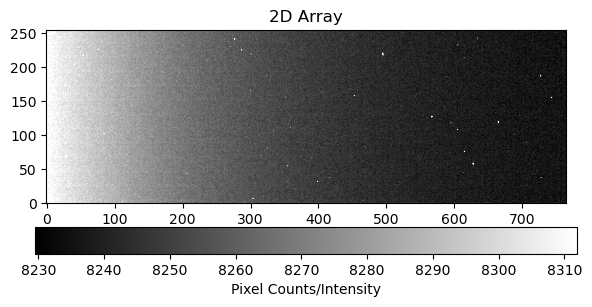

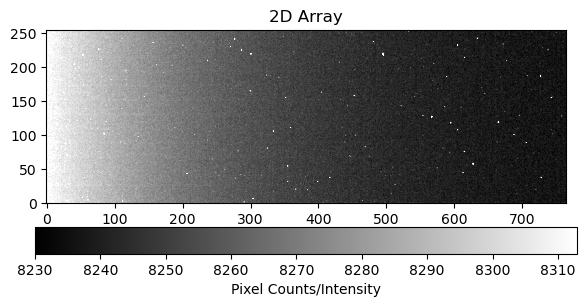

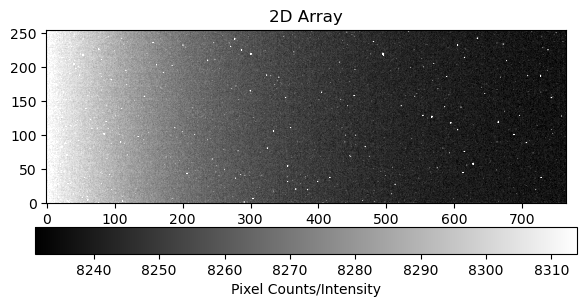

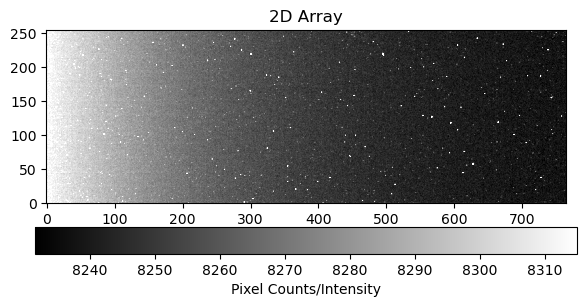

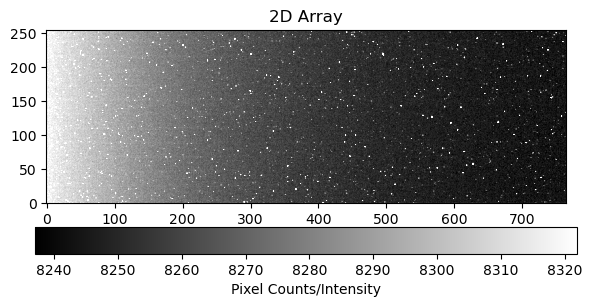

In [8]:
show_files = True
show_arrays = True
darks_exposure_times = ['dark_3s', 'dark_10s', 'dark_15s', 'dark_25s', 'dark_60s']
darks_mcombines = {}
darks_mcombines_unc = {}

for exposure in darks_exposure_times:
    fits_files = glob_files('night_2', exposure, show=show_files)
    darks_mcombines[exposure], darks_mcombines_unc[exposure] = calibrate_fits_files(fits_file_list=fits_files, display_array=show_arrays)    
    #display_2d_array(darks_mcombines_unc[exposure])
    #plt.title(f'{exposure} uncertainty')
    #print(exposure, np.max(darks_mcombines_unc[exposure]))
    
for i in darks_mcombines:
    print(f"Avg pixel value in {i}: {np.mean(darks_mcombines[i])}")
    
print('Darks Median Combines')
for key, value in darks_mcombines.items():
    print(f"{key}, {np.shape(value)}")

##### Calibration Spectra

Number of Files: 10
night_2\ha_neon_calibration_spectrum_set1_15s.00000000.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000001.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000002.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000003.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000004.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000005.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000006.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000007.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000008.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000009.FIT
Number of Files: 10
night_2\ha_neon_calibration_spectrum_set2_15s.00000000.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000001.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000002.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000003.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000004.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000005.FIT
night_2\ha_neon_

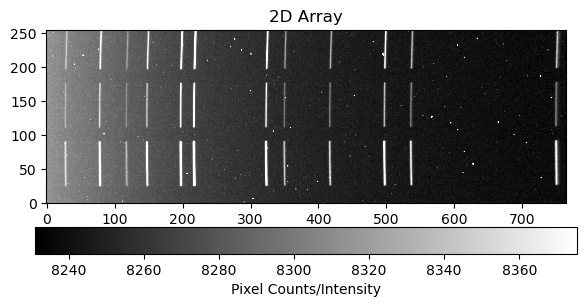

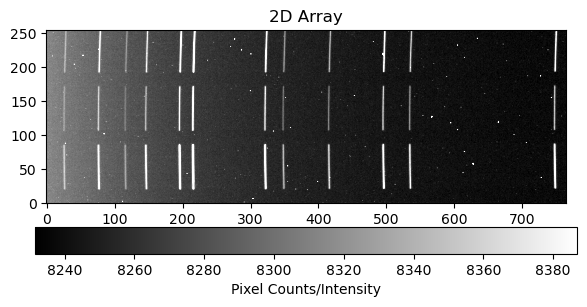

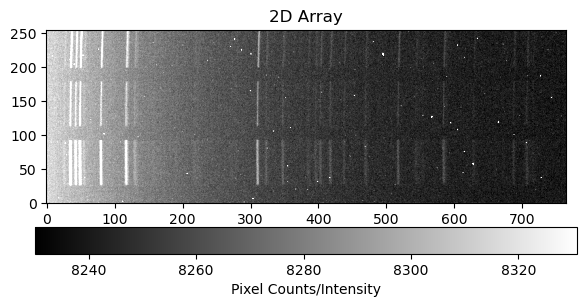

In [10]:
show_files = True
show_arrays = True
spectra = ['ha_neon_calibration_spectrum_set1', 'ha_neon_calibration_spectrum_set2_15s', 'hbg_argon_calibration_spectrum_sets1and2']
spectra_calib = {}
spectra_calib_unc = {}

for spectrum in spectra:
    fits_files = glob_files('night_2', spectrum, show=show_files)
    spectra_calib[spectrum], spectra_calib_unc[spectrum] = calibrate_fits_files(fits_file_list=fits_files, display_array=show_arrays)
    #display_2d_array(spectra_calib_unc[spectrum])
new_keys = {
    'ha_neon_calibration_spectrum_set1': 'neon_set1_15s',
    'ha_neon_calibration_spectrum_set2_15s': 'neon_set2_15s',
    'hbg_argon_calibration_spectrum_sets1and2': 'argon_10s'
}
for dictionary in [spectra_calib, spectra_calib_unc]:
    updated_dict = {new_keys.get(old_key, old_key): value for old_key, value in dictionary.items()}
    dictionary.clear()
    dictionary.update(updated_dict)

print('Spectra Median Combines')
for key, value in spectra_calib.items():
    print(f"{key}, {np.shape(value)}")

##### Flats

Number of Files: 10
night_2\Ha_Neon_flats_3s.00000000.FIT
night_2\Ha_Neon_flats_3s.00000001.FIT
night_2\Ha_Neon_flats_3s.00000002.FIT
night_2\Ha_Neon_flats_3s.00000003.FIT
night_2\Ha_Neon_flats_3s.00000004.FIT
night_2\Ha_Neon_flats_3s.00000005.FIT
night_2\Ha_Neon_flats_3s.00000006.FIT
night_2\Ha_Neon_flats_3s.00000007.FIT
night_2\Ha_Neon_flats_3s.00000008.FIT
night_2\Ha_Neon_flats_3s.00000009.FIT
Number of Files: 5
night_2\hbg_flat_spectrum_sets1and2_60s.00000000.FIT
night_2\hbg_flat_spectrum_sets1and2_60s.00000001.FIT
night_2\hbg_flat_spectrum_sets1and2_60s.00000002.FIT
night_2\hbg_flat_spectrum_sets1and2_60s.00000003.FIT
night_2\hbg_flat_spectrum_sets1and2_60s.00000004.FIT
Flats Median Combines
HaNe_flats_3s, (255, 765)
HbgAr_flats_60s, (255, 765)


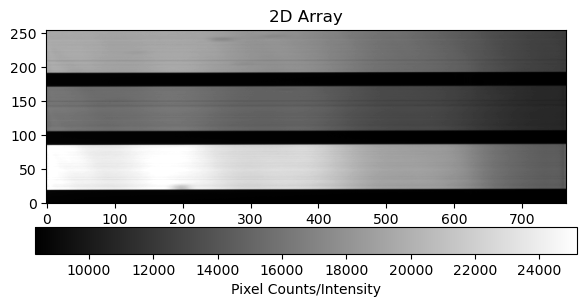

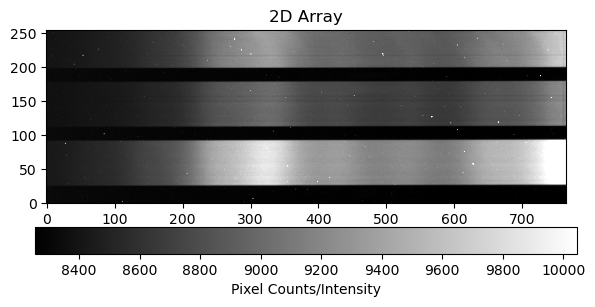

In [12]:
show_files = True
show_arrays = True
flats_names = ['Ha_Neon_flats_3s', 'hbg_flat_spectrum_sets1and2']
flats_mcombines = {}
flats_mcombines_unc = {}

for name in flats_names:
    fits_files = glob_files('night_2', name, show=show_files)
    flats_mcombines[name], flats_mcombines_unc[name] = calibrate_fits_files(fits_file_list=fits_files, display_array=show_arrays)
    #display_2d_array(flats_mcombines_unc[name])
    
new_keys = {
    'Ha_Neon_flats_3s': 'HaNe_flats_3s',
    'hbg_flat_spectrum_sets1and2': 'HbgAr_flats_60s',
}
for dictionary in [flats_mcombines, flats_mcombines_unc]:
    updated_dict = {new_keys.get(old_key, old_key): value for old_key, value in dictionary.items()}
    dictionary.clear()
    dictionary.update(updated_dict)

print('Flats Median Combines')
for key, value in flats_mcombines.items():
    print(f"{key}, {np.shape(value)}")

##### Science Frames

Number of Files: 20
night_2\ha_lights_set1_25s.00000000.FIT
night_2\ha_lights_set1_25s.00000001.FIT
night_2\ha_lights_set1_25s.00000002.FIT
night_2\ha_lights_set1_25s.00000003.FIT
night_2\ha_lights_set1_25s.00000004.FIT
night_2\ha_lights_set1_25s.00000005.FIT
night_2\ha_lights_set1_25s.00000006.FIT
night_2\ha_lights_set1_25s.00000007.FIT
night_2\ha_lights_set1_25s.00000008.FIT
night_2\ha_lights_set1_25s.00000009.FIT
night_2\ha_lights_set1_25s.00000010.FIT
night_2\ha_lights_set1_25s.00000011.FIT
night_2\ha_lights_set1_25s.00000012.FIT
night_2\ha_lights_set1_25s.00000013.FIT
night_2\ha_lights_set1_25s.00000014.FIT
night_2\ha_lights_set1_25s.00000015.FIT
night_2\ha_lights_set1_25s.00000016.FIT
night_2\ha_lights_set1_25s.00000017.FIT
night_2\ha_lights_set1_25s.00000018.FIT
night_2\ha_lights_set1_25s.00000019.FIT
Number of Files: 20
night_2\ha_lights_set2_25s.00000000.FIT
night_2\ha_lights_set2_25s.00000001.FIT
night_2\ha_lights_set2_25s.00000002.FIT
night_2\ha_lights_set2_25s.00000003.FIT


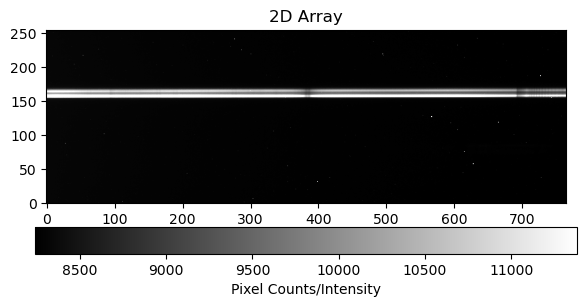

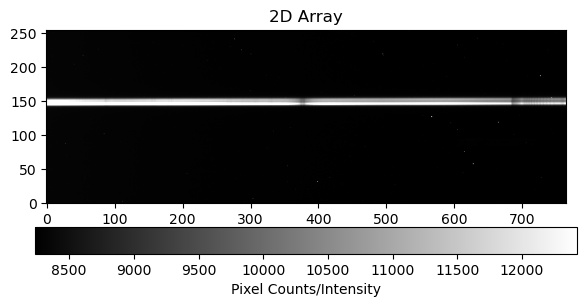

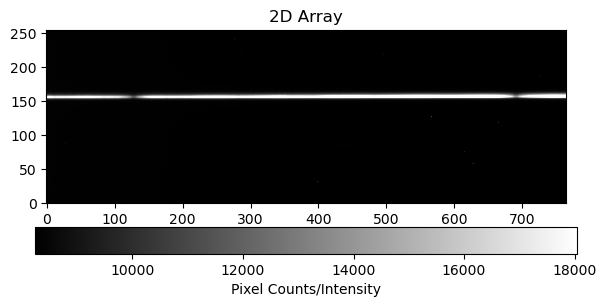

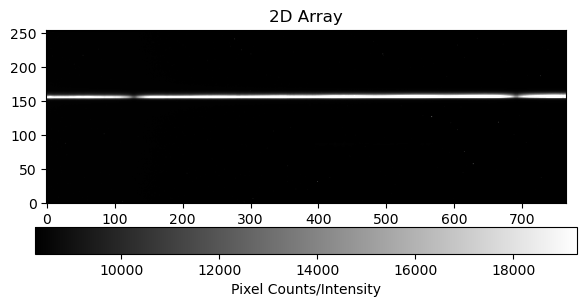

In [14]:
show_files = True
show_arrays = True
names = ['ha_lights_set1', 'ha_lights_set2', 'hbg_light_set1', 'hbg_light_set2']
sci_mcombines = {}
sci_mcombines_unc = {}
for name in names:
    fits_files = glob_files('night_2', name, show=show_files)
    sci_mcombines[name], sci_mcombines_unc[name] = calibrate_fits_files(fits_file_list=fits_files, display_array=show_arrays) #
    #display_2d_array(sci_mcombines_unc[name])
    
new_keys = {
    'ha_lights_set1': 'Ha_sci_set1',
    'ha_lights_set2': 'Ha_sci_set2',
    'hbg_light_set1': 'Hbg_sci_set1',
    'hbg_light_set2': 'Hbg_sci_set2',
}
for dictionary in [sci_mcombines, sci_mcombines_unc]:
    updated_dict = {new_keys.get(old_key, old_key): value for old_key, value in dictionary.items()}
    dictionary.clear()
    dictionary.update(updated_dict)
    
print('Science Median Combines')
for key, value in sci_mcombines.items():
    print(f"{key}, {np.shape(value)}")

Sanity Check

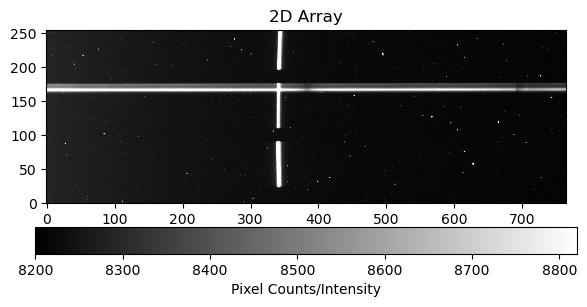

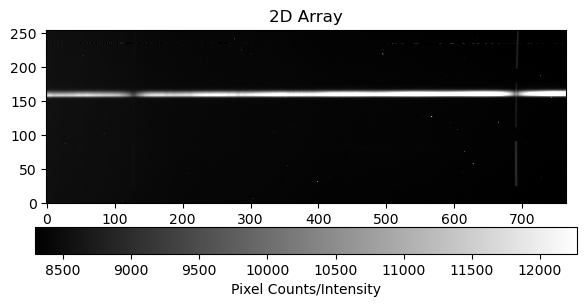

In [16]:
calibrate_fits_files(fits_file_list=glob_files('night_2','ha_laser_sanity'), display_array=True)
calibrate_fits_files(fits_file_list=glob_files('night_2','hbg_Hlamp_spectrum_sanity'), display_array=True)
print()

Dicts: \
darks_mcombines \
spectra_calib \
flats_mcombines \
sci_mcombines

### Dark Correction
These will all be stored in dictionaries named:  
- *`name_dcorr`*  
- *`name_dcorr_unc`*


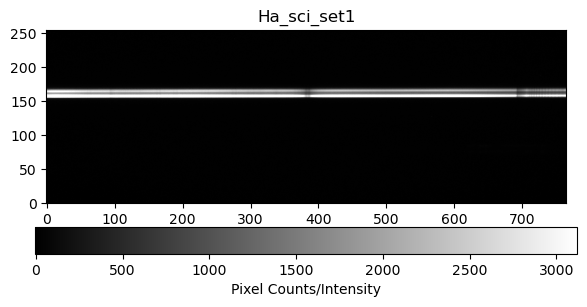

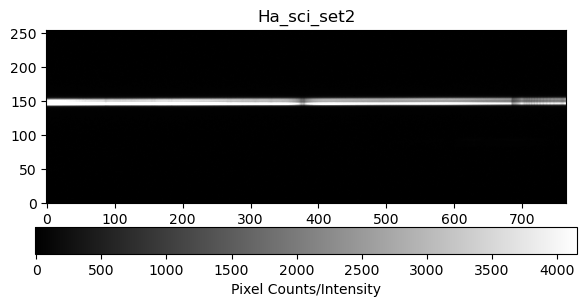

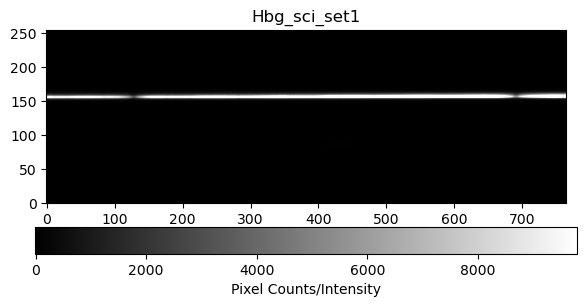

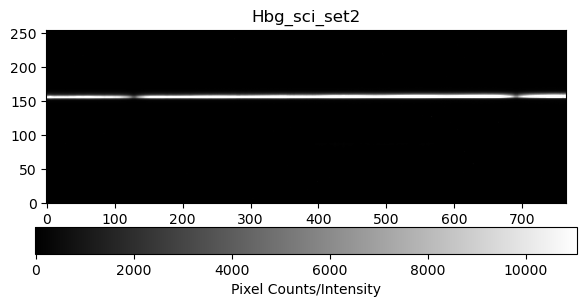

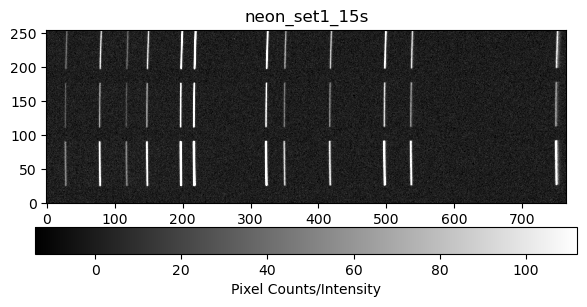

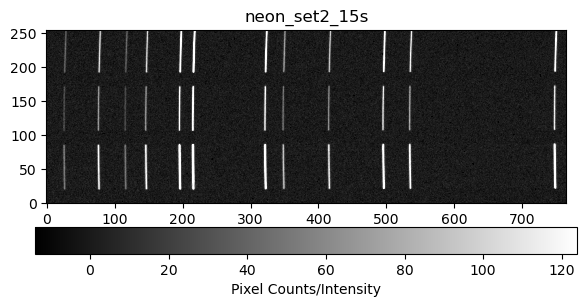

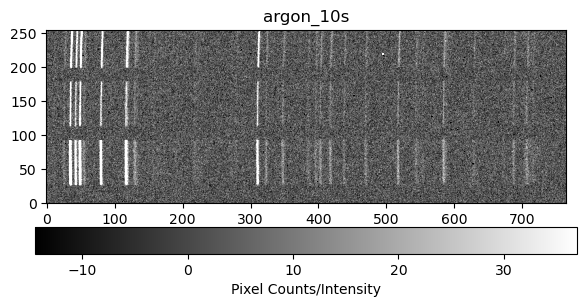

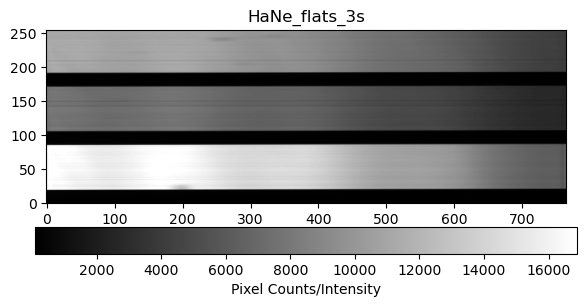

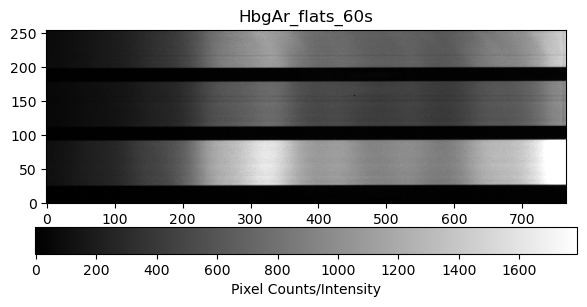

In [19]:
spectra_dcorr = spectra_calib.copy()
flats_dcorr = flats_mcombines.copy()
sci_dcorr = sci_mcombines.copy()
spectra_dcorr_unc = spectra_calib.copy()
flats_dcorr_unc = flats_mcombines.copy()
sci_dcorr_unc = sci_mcombines.copy()

os.makedirs('calibrated_fits', exist_ok=True)

#Science:
for (key, value), (key_u, value_u) in zip(sci_mcombines.items(), sci_mcombines_unc.items()):
    sci_dcorr[key] = darks_correction(value, darks_mcombines['dark_25s'])
    sci_dcorr_unc[key_u] = darks_correction_uncertianty(value_u, darks_mcombines_unc['dark_25s'])
    display_2d_array(sci_dcorr[key], title=key)
    #display_2d_array(sci_dcorr[key] + sci_dcorr_unc[key], title=key)
    save_array_to_fits_file(sci_dcorr[key], path.join('calibrated_fits', 'sci_' + key + 'dark_correction.FIT'))

#Spectra:
darks_order = ['dark_15s','dark_15s','dark_10s']
for (key, value), dark_key in zip(spectra_calib.items(), darks_order):
    spectra_dcorr[key] = darks_correction(value, darks_mcombines[dark_key])
    spectra_dcorr_unc[key] = darks_correction_uncertianty(spectra_calib_unc[key], darks_mcombines_unc[dark_key])
    display_2d_array(spectra_dcorr[key], title=key)
    #display_2d_array(spectra_dcorr[key] + spectra_dcorr_unc[key], title=key)
    save_array_to_fits_file(spectra_dcorr[key], path.join('calibrated_fits', 'spec_' +  key + 'dark_correction.FIT'))

#Flats
darks_order = ['dark_3s','dark_60s']
for (key, value), dark_key in zip(flats_mcombines.items(), darks_order):
    flats_dcorr[key] = darks_correction(value, darks_mcombines[dark_key])
    flats_dcorr_unc[key] = darks_correction_uncertianty(flats_mcombines_unc[key], darks_mcombines_unc[dark_key])
    display_2d_array(flats_dcorr[key], title=key)
    #display_2d_array(flats_dcorr[key] + flats_dcorr_unc[key], title=key)
    save_array_to_fits_file(flats_dcorr[key], path.join('calibrated_fits', 'flat_' +  key + 'dark_correction.FIT'))

### Cut Arrays
We need to cut these arrays to only look at the slit that our star is in ($25 \mu m$). We will worry about obtaining the target signal from the science frames in the Gaussian Cutting section.\
Looking at the flats in ds9, here are the cut ranges for our frames: \
\
H$\alpha$ and Neon:  $107$ $\le$ $y_{pix}$ $\le$ $171$ \
H$\beta$, H$\gamma$ (Set 1):  $114$ $\le$ $y_{pix}$ $\le$ $177$

Lets cut these science arrays first

Ha_sci_set1, (64, 765)
Ha_sci_set2, (64, 765)
Hbg_sci_set1, (63, 765)
Hbg_sci_set2, (63, 765)


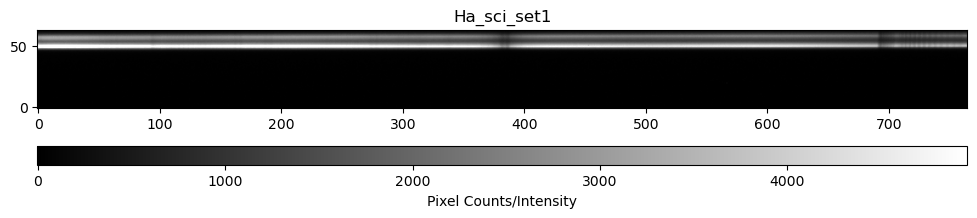

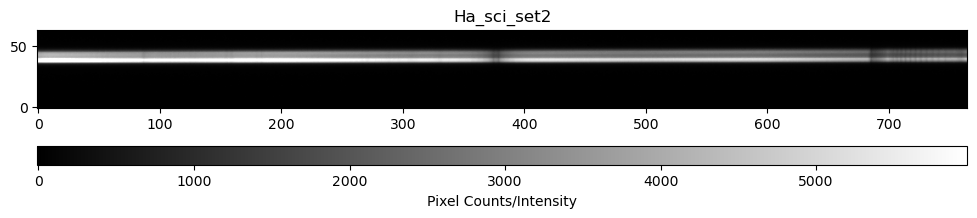

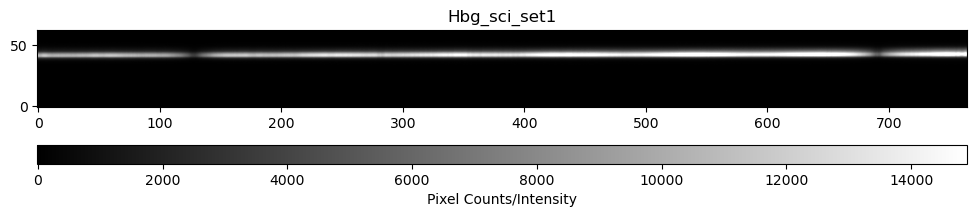

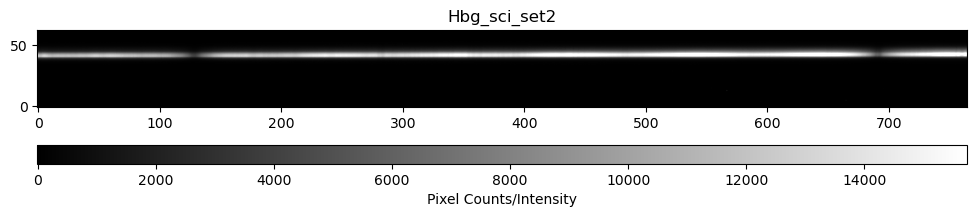

In [22]:
#Create a dict of cuts
cut1 = [107,171]
cut2 = [114,177]
cuts_dict = {'Ha_1' : cut1,
             'Ha_2' : cut1,
             'Hgb_1' : cut2,
             'Hgb_2' : cut2,
             }
#Create dicts to store cut arrays
sci_cut = sci_dcorr.copy()
sci_cut_unc = sci_dcorr_unc.copy()
os.makedirs('cut_fits', exist_ok=True) #New directory

#Perform cuts
for (key, value), cut_key in zip(sci_cut.items(), cuts_dict):
    sci_cut[key] = cut_pixel_data_array(value, *cuts_dict[cut_key])
    sci_cut_unc[key] = cut_pixel_data_array(sci_cut_unc[key], *cuts_dict[cut_key])
    display_cut_spectrum(sci_cut[key], title=key)
    save_array_to_fits_file(sci_cut[key], path.join('cut_fits', 'sci_' +  key + '_cut.FIT'))

for key, value in sci_cut.items():
    print(f"{key}, {np.shape(value)}")

Now cut the flats and calibration spectra

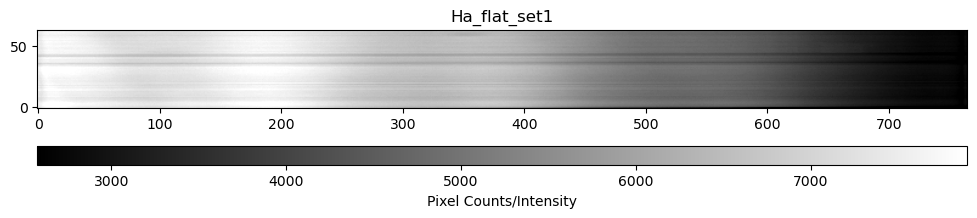

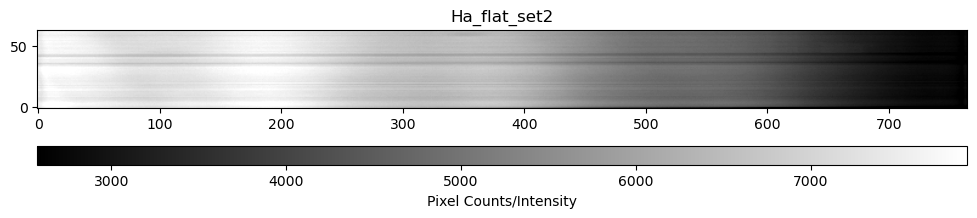

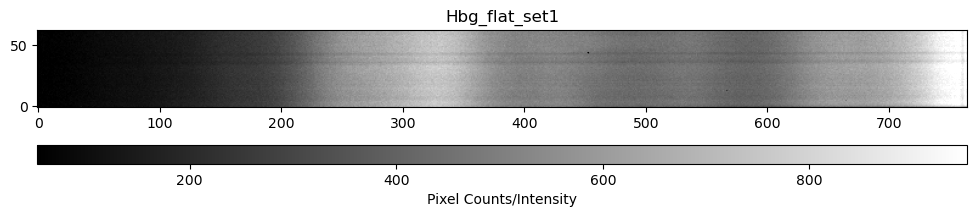

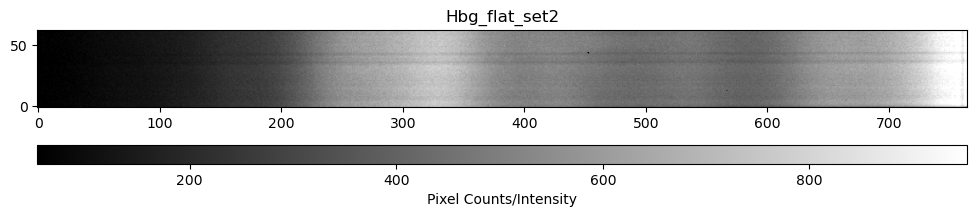

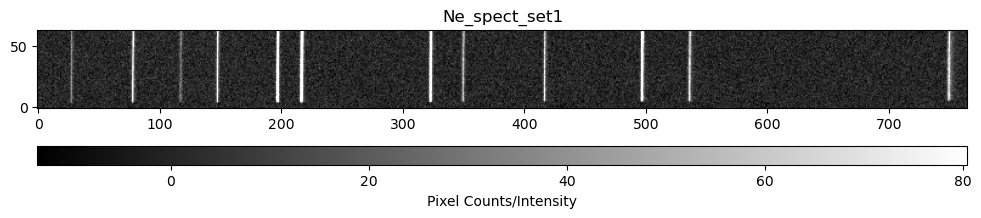

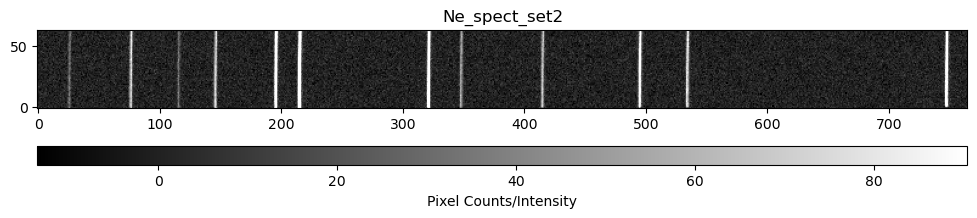

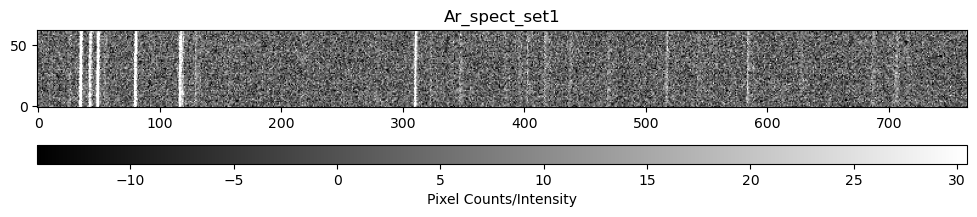

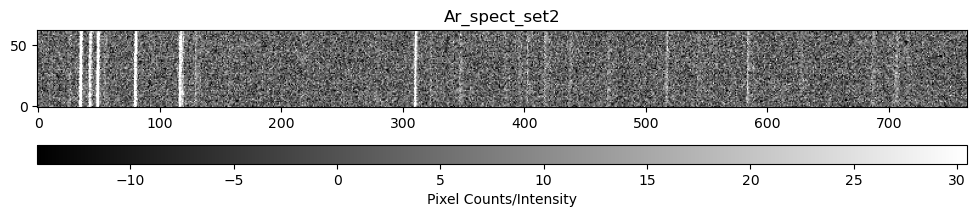

In [24]:
flats_cut = flats_dcorr.copy()
flats_cut_unc = flats_dcorr_unc.copy()
spectra_cut = spectra_dcorr.copy()
spectra_cut_unc = spectra_dcorr_unc.copy()

flats_cut = {'Ha_flat_set1' : cut_pixel_data_array(flats_dcorr['HaNe_flats_3s'], *cuts_dict['Ha_1']),
             'Ha_flat_set2' : cut_pixel_data_array(flats_dcorr['HaNe_flats_3s'], *cuts_dict['Ha_2']),
             'Hbg_flat_set1' : cut_pixel_data_array(flats_dcorr['HbgAr_flats_60s'], *cuts_dict['Hgb_1']),
             'Hbg_flat_set2' : cut_pixel_data_array(flats_dcorr['HbgAr_flats_60s'], *cuts_dict['Hgb_2']),
            }
flats_cut_unc = {'Ha_flat_set1' : cut_pixel_data_array(flats_dcorr_unc['HaNe_flats_3s'], *cuts_dict['Ha_1']),
                 'Ha_flat_set2' : cut_pixel_data_array(flats_dcorr_unc['HaNe_flats_3s'], *cuts_dict['Ha_2']),
                 'Hbg_flat_set1' : cut_pixel_data_array(flats_dcorr_unc['HbgAr_flats_60s'], *cuts_dict['Hgb_1']),
                 'Hbg_flat_set2' : cut_pixel_data_array(flats_dcorr_unc['HbgAr_flats_60s'], *cuts_dict['Hgb_2']),
                }
spectra_cut = {'Ne_spect_set1' : cut_pixel_data_array(spectra_dcorr['neon_set1_15s'], *cuts_dict['Ha_1']),
               'Ne_spect_set2' : cut_pixel_data_array(spectra_dcorr['neon_set2_15s'], *cuts_dict['Ha_2']),
               'Ar_spect_set1' : cut_pixel_data_array(spectra_dcorr['argon_10s'], *cuts_dict['Hgb_1']),
               'Ar_spect_set2' : cut_pixel_data_array(spectra_dcorr['argon_10s'], *cuts_dict['Hgb_2']),
              }
spectra_cut_unc = {'Ne_spect_set1' : cut_pixel_data_array(spectra_dcorr_unc['neon_set1_15s'], *cuts_dict['Ha_1']),
                   'Ne_spect_set2' : cut_pixel_data_array(spectra_dcorr_unc['neon_set2_15s'], *cuts_dict['Ha_2']),
                   'Ar_spect_set1' : cut_pixel_data_array(spectra_dcorr_unc['argon_10s'], *cuts_dict['Hgb_1']),
                   'Ar_spect_set2' : cut_pixel_data_array(spectra_dcorr_unc['argon_10s'], *cuts_dict['Hgb_2']),
                  }

for key,value in flats_cut.items():
    display_cut_spectrum(flats_cut[key], title=key)
    save_array_to_fits_file(flats_cut[key], path.join('cut_fits', 'flat_' +  key + '_cut.FIT'))
    
for key,value in spectra_cut.items():
    display_cut_spectrum(spectra_cut[key], title=key) 
    save_array_to_fits_file(spectra_cut[key], path.join('cut_fits', 'spect_' +  key + '_cut.FIT'))

### Flat Correction
We will try two different methods

In [26]:
Polyfit = True
FlatDivision = False

#### Method 1: Polynomial Fit
Now it is time for the flat correction. Here are the steps:
1) Take the 2D array of the flat field and find the median value of each column. This will create a 1D array with intensity values corresponding to horizontal pixel positions.
2) Plot the 1D array vs pixel position.
3) Fit a polynomial through the intensity curve.
4) Divide all data by this curve fit.

##### 1 and 2) Creating 1D Flat Field Arrays and Plotting Along Dispersion Axis

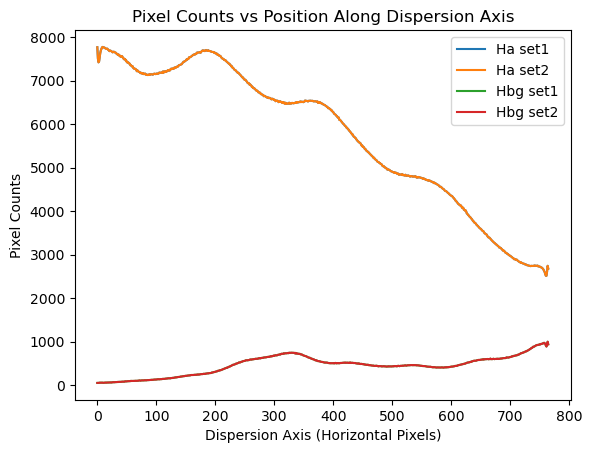

In [29]:
if Polyfit:
    flat_field_col_medians = {}
    flat_field_col_medians_unc = {}
    
    for key,value in flats_cut.items():
        flat_field_col_medians[key + '_col_median'] = np.median(value, axis=0)
        flat_field_col_medians_unc[key + '_col_median'] = median_uncertainty(value, axis=0)
        
    indices = np.arange(len(flat_field_col_medians['Ha_flat_set1_col_median']))
    
    for key,value in flat_field_col_medians.items():
        label = key.replace('_flat_',' ').replace('_col_median','')
        plt.plot(indices, value, label=label, ls='solid',)# marker='.', ms=0)
        #plt.errorbar(indices, value, yerr=flat_field_col_medians_unc[key], fmt='.', ms=1, lw=1,label=label + ' Uncertainty')
        plt.title('Pixel Counts vs Position Along Dispersion Axis')
        plt.xlabel('Dispersion Axis (Horizontal Pixels)')
        plt.ylabel('Pixel Counts')
        plt.legend()
        plt.plot()

##### 3 and 4) Polynomial Fit and Flat Normalization

Ha_flat_set1_col_median Ha_flat_set1
Ha_flat_set2_col_median Ha_flat_set2
Hbg_flat_set1_col_median Hbg_flat_set1
Hbg_flat_set2_col_median Hbg_flat_set2


C:\Users\antho\AppData\Local\Temp\ipykernel_19508\234174295.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(indices, med_values, deg=degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_19508\234174295.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(indices, med_values, deg=degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_19508\234174295.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(indices, med_values, deg=degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_19508\234174295.py:16: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(indices, med_values, deg=degree)


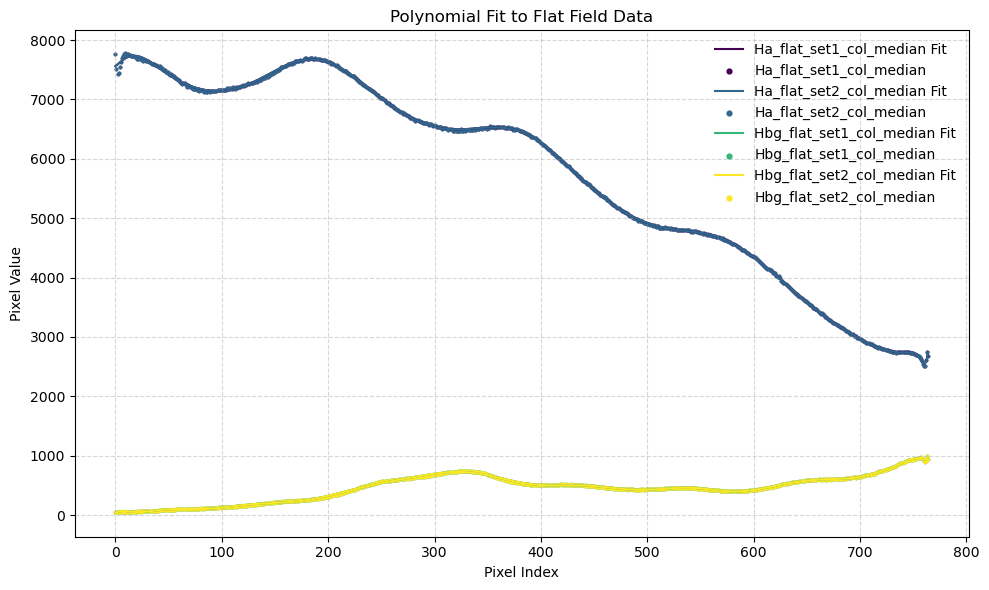

In [31]:
if Polyfit:
    specific_plot = False
    specific_plot_label = 'Ha_flat_set1'
    os.makedirs('normalized_fits', exist_ok=True)
    normalized_flat_fields = {}
    normalized_flat_fields_unc = {}
    degree = 50
    fig, ax = plt.subplots(figsize=(10,6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(flat_field_col_medians))) #plasma viridis
    
    for i, ((med_key, med_values), (cut_flat_key, cut_flat_values)) in enumerate(zip(flat_field_col_medians.items(), flats_cut.items())): 
        if specific_plot:
            if cut_flat_key != specific_plot_label:  # Change the condition to choose which set to display
                continue
        print(med_key,cut_flat_key)
        coefficients = np.polyfit(indices, med_values, deg=degree)
        polynomial_fit = np.polyval(coefficients, indices)
        polynomial_fit_2d = np.tile(polynomial_fit, (cut_flat_values.shape[0], 1))
        ax.plot(indices, polynomial_fit, color=colors[i], label=f'{med_key} Fit')
        ax.scatter(indices, med_values, marker='o', s=3, color=colors[i], label=f'{med_key}')
        ax.set_ylabel('Pixel Value')
        ax.set_xlabel('Pixel Index')
        ax.set_title('Polynomial Fit to Flat Field Data')
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.legend()
        
        normalized_flat_fields[cut_flat_key] = flats_cut[cut_flat_key] / polynomial_fit_2d
        normalized_flat_fields_unc[cut_flat_key] = flats_cut_unc[cut_flat_key] / polynomial_fit_2d   # good approximation if the fit is good      
        save_array_to_fits_file(normalized_flat_fields[cut_flat_key], path.join('normalized_fits', 'norm_' +  cut_flat_key + '.FIT'))
        
    ax.legend(loc='upper right', frameon=False, fontsize=10, markerscale=2)
    # Show the plot
    plt.tight_layout()  # Adjusts layout to fit everything
    plt.show()

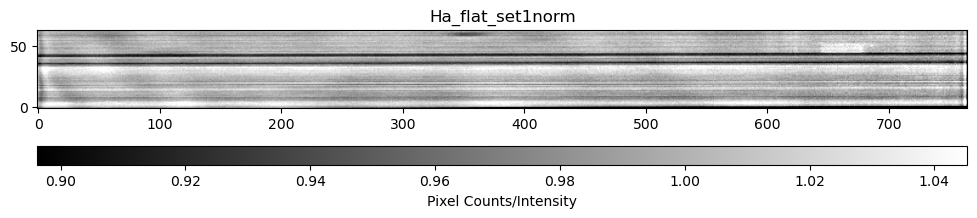

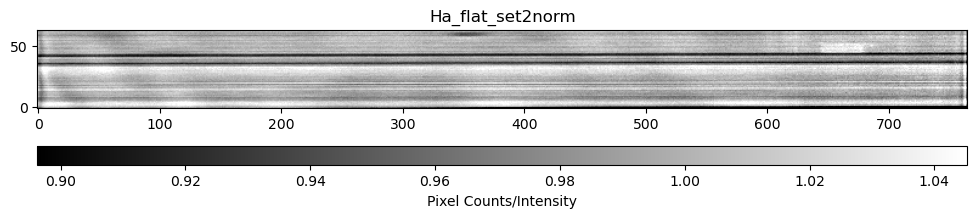

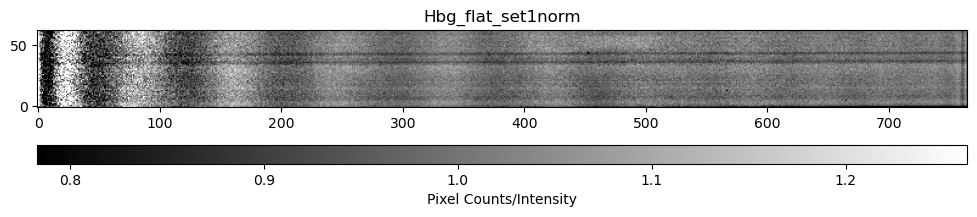

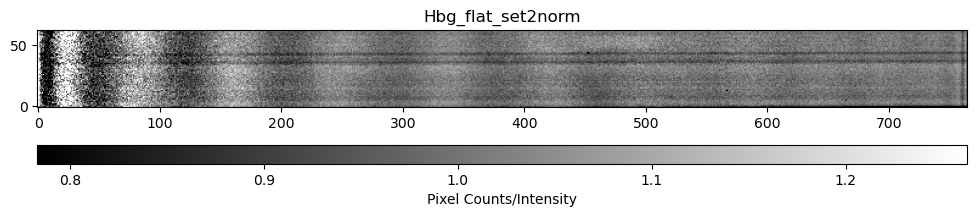

In [32]:
if Polyfit:
    for key, values in normalized_flat_fields.items():
        display_cut_spectrum(values, title=key+'norm')

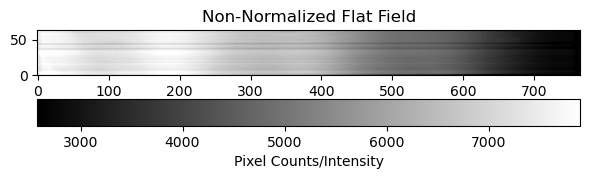

In [33]:
if Polyfit:
    display_2d_array(flats_cut['Ha_flat_set1'])
    plt.title('Non-Normalized Flat Field')

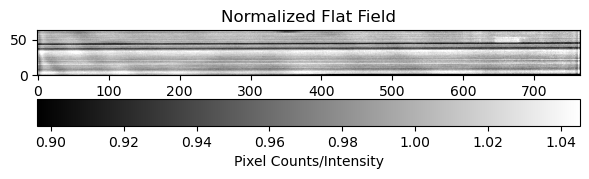

In [34]:
if Polyfit:
    display_2d_array(normalized_flat_fields['Ha_flat_set1'])
    plt.title('Normalized Flat Field')

Now we have to finish calibrating our spectra (both sci and calibration) by dividing by the flat field

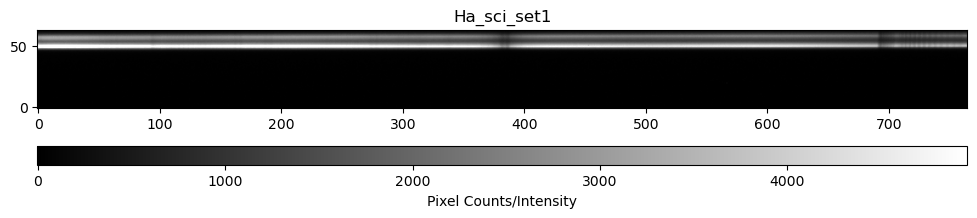

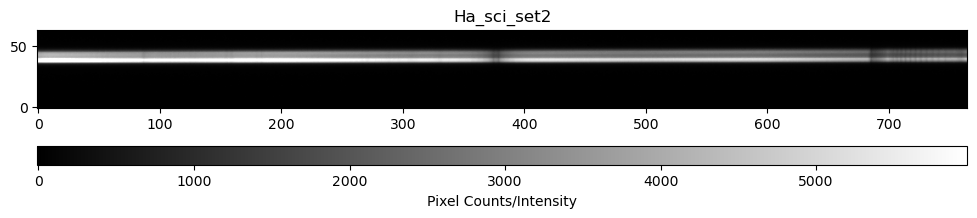

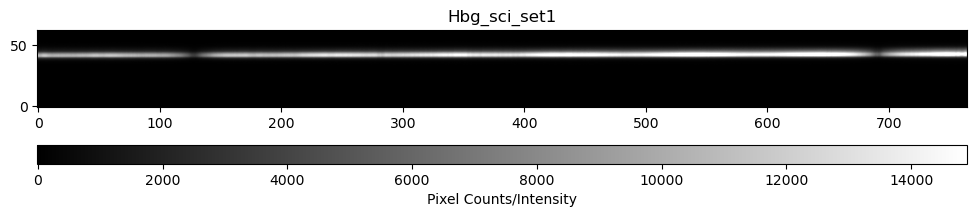

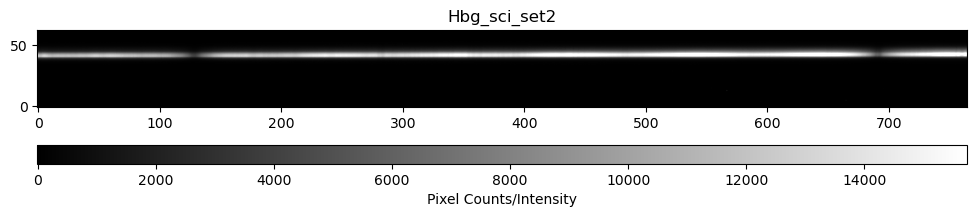

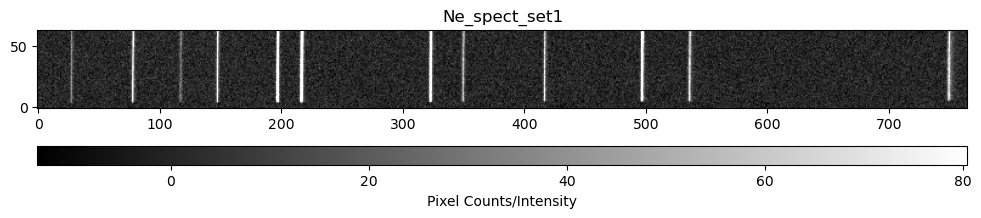

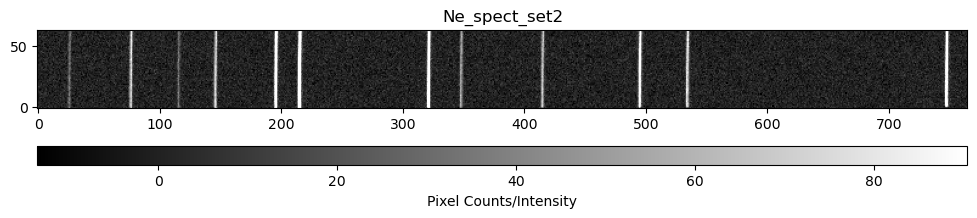

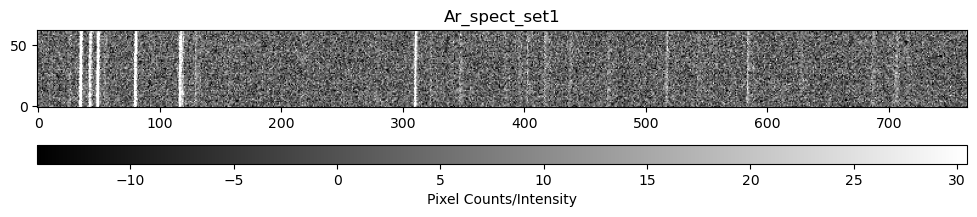

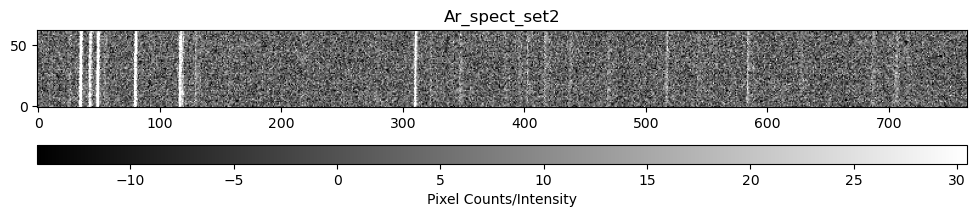

In [36]:
def uncertainty_division(numerator, denominator, numerator_unc, denominator_unc):
    #epsilon = 1e-10  # Small value to prevent division by zero
    #safe_denominator = np.where(denominator == 0, epsilon, denominator)
    var1 = np.square(numerator_unc / denominator)
    var2 = np.square((numerator * denominator_unc) / np.square(denominator))
    return np.sqrt(var1 + var2)

if Polyfit: 
    calibrated_science = sci_cut.copy()
    calibrated_science_unc = sci_cut_unc.copy()
    calibrated_spectra = spectra_cut.copy()
    calibrated_spectra_unc = spectra_cut_unc.copy()

    os.makedirs('finalized_spectra', exist_ok=True)
    for (key, value), (flat_key, flat_value) in zip(calibrated_science.items(), normalized_flat_fields.items()):
        calibrated_science[key] = value / flat_value 
        calibrated_science_unc[key] = uncertainty_division(sci_cut[key], normalized_flat_fields[flat_key], sci_cut_unc[key], normalized_flat_fields_unc[flat_key])
        display_cut_spectrum(value, title=key)
        save_array_to_fits_file(value, path.join('finalized_spectra',f'calibrated_{key}.FIT'))
    for (key, value), (flat_key, flat_value), (skey,svalue) in zip(calibrated_spectra.items(), normalized_flat_fields.items(), spectra_cut.items()):
        calibrated_spectra[key] = value / flat_value   
        calibrated_spectra_unc[key] = uncertainty_division(spectra_cut[skey], normalized_flat_fields[flat_key], spectra_cut_unc[skey], normalized_flat_fields_unc[flat_key])
        display_cut_spectrum(value, title=key)
        save_array_to_fits_file(value, path.join('finalized_spectra',f'calibrated_{key}.FIT'))

#### Method 2: Flat Field Division

##### Normalize The Flat Fields
Divide the flat fields by the median of the flat field to normalize them, \
The intensity of the calibration spectrum does not matter as much to us so we are okay with proceeding cosi

In [39]:
if FlatDivision:
    value = flats_cut['Ha_flat_set1']
    print(np.median(value),np.mean(value))
    plt.hist(value.flatten(), bins=50, range=(0, np.max(value)), histtype='step', color='blue')
    plt.plot()

In [40]:
if FlatDivision:
    normalized_flat_fields = flats_cut.copy()
    normalized_flat_fields_unc = flats_cut_unc.copy()
    for (key,value), (ukey,uvalue) in zip(normalized_flat_fields.items(), normalized_flat_fields_unc.items()):
        print(np.median(value),np.mean(value))
        v = value / np.median(value)
        normalized_flat_fields[key] = v
        print(np.median(value),np.mean(value))
        normalized_flat_fields_unc[ukey] = uvalue / np.median(value)
        #print(np.median(normalized_flats_unc[ukey]))

##### Apply Flat Correction

In [42]:
#Display normalized flat fields
if FlatDivision:
    for key, values in normalized_flat_fields.items():
        display_cut_spectrum(values, title=key+'norm')

In [43]:
if FlatDivision:
    calibrated_science = sci_cut.copy()
    calibrated_science_unc = sci_cut_unc.copy()
    calibrated_spectra = spectra_cut.copy()
    calibrated_spectra_unc = spectra_cut_unc.copy()
    
    for (key,value), (ukey,uvalue), (fkey,fvalue), (ufkey, ufvalue) in zip(calibrated_science.items(), 
                calibrated_science_unc.items(), normalized_flat_fields.items(), normalized_flat_fields_unc.items()):
        #print(key,ukey,fkey,ufkey)
        calibrated_science[key] = value / fvalue 
        calibrated_science_unc[ukey] = flat_correction_uncertainty(value,uvalue,fvalue,ufvalue)
        
    for (key,value), (ukey,uvalue), (fkey,fvalue), (ufkey, ufvalue) in zip(calibrated_spectra.items(), 
                calibrated_spectra_unc.items(), normalized_flat_fields.items(), normalized_flat_fields_unc.items()):
        calibrated_spectra[key] = value / fvalue 
        calibrated_spectra_unc[ukey] = flat_correction_uncertainty(value,uvalue,fvalue,ufvalue)

In [44]:
#Testing
if FlatDivision:
    value_2d = spectra_dcorr['neon_set1_15s']
    value = value_2d.flatten()
    print(len(value))
    uncert = spectra_dcorr_unc['neon_set1_15s']
    plot=False
    if plot==True:
        #plt.xlim(25000,26000)
        #plt.ylim(8200,8500)
        plt.scatter(x=np.arange(len(value)), y=value, marker='.', s=1,label='1')
        plt.errorbar(x=np.arange(len(value)), y=value, yerr=uncert.flatten(), fmt='.',label='2',capsize=2)
        plt.legend()
    max_index_flat = np.argmax(uncert)
    max_coordinates = np.unravel_index(max_index_flat, uncert.shape)
    max_uncert = uncert[max_coordinates]
    corr_value = value_2d[max_coordinates]
    print(f"Coords: {max_coordinates}, Value: {corr_value:.3f} +- {max_uncert:.3f}, MagRatio = {np.log10((corr_value/max_uncert))}")

In [45]:
if FlatDivision:
    value = calibrated_science['Hbg_sci_set1']
    print(np.median(value),np.mean(value), np.std(value))
    plt.hist(value.flatten(), bins=50, range=(0, np.max(value)), histtype='step', color='blue')
    plt.plot()

##### Show Flat Corrected Data

In [47]:
if FlatDivision:
    for key,value in calibrated_science.items():
        display_cut_spectrum(value,title=key)
        #display_cut_spectrum(calibrated_science_unc[key], title=key+'unc')
        #display_cut_spectrum(value - calibrated_science_unc[key], title=key+'+unc')
        save_array_to_fits_file(value, path.join('finalized_spectra',f'calibrated_{key}_V2.FIT'))
    for key,value in calibrated_spectra.items():
        display_cut_spectrum(value,title=key)
        #display_cut_spectrum(calibrated_spectra_unc[key], title=key+'unc')
        #display_cut_spectrum(value - calibrated_spectra_unc[key], title=key+'+unc')
        save_array_to_fits_file(value, path.join('finalized_spectra',f'calibrated_{key}_V2.FIT'))

## Wavelength Calibration
First, we matched spectral lines from our spectrum to emission lines of the actual neon spectrum, and we made a list of pixel positions that lined up with emission wavelengths from the NIST website.
We will show how to fit a linear function to a plot of pixel positions vs wavelength to derive a wavelength calibration formula. 

    x_pixel_set1  x_pixel_set2  wavelength  delta
0         29.164        27.550   621.72810  1.614
1         76.730        77.380   626.64950 -0.650
2        118.989       117.110   630.47893  1.879
3        149.220       147.635   633.44280  1.585
4        199.176       197.200   638.29900  1.976
5        218.647       216.600   640.22500  2.047
6        324.402       322.900   650.65277  1.502
7        351.690       349.416   653.28820  2.274
8        418.493       416.450   660.29007  2.043
9        498.650       496.600   667.82766  2.050
10       537.600       535.481   671.70430  2.119
11       750.965       748.945   692.94672  2.020
Index(['x_pixel_set1', 'x_pixel_set2', 'wavelength', 'delta'], dtype='object')
Ne_x_index_set1==> Slope: 0.099, Intercept: 618.937
Ne_x_index_set2==> Slope: 0.099, Intercept: 619.055


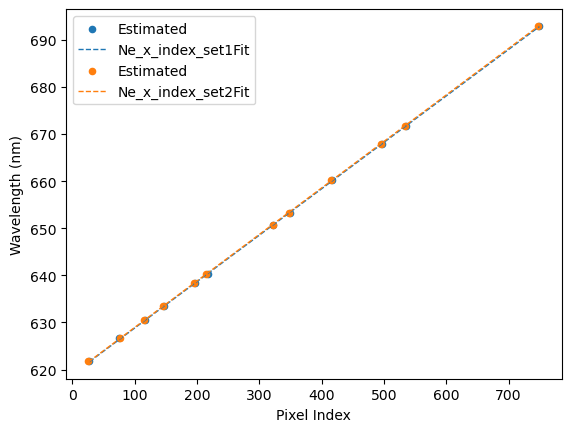

In [49]:
def pixel_to_wavelength_index(x,slope,b):
    return slope*x + b
    
pix_vs_wavelength = pd.read_csv('Ne_pixels_vs_wavelength.csv')
print(pix_vs_wavelength)
print(pix_vs_wavelength.columns)
pix_vs_wavelength['Ne_x_index_set1'] = pix_vs_wavelength['x_pixel_set1'] - 1.5 #****** starts at 0.5 not 0
pix_vs_wavelength['Ne_x_index_set2'] = pix_vs_wavelength['x_pixel_set2'] - 1.5
uncertainty = np.ones(len(pix_vs_wavelength['x_pixel_set1']))

indices = ['Ne_x_index_set1', 'Ne_x_index_set2']
wavelengths = pix_vs_wavelength['wavelength']
calibration_stats = {}
for index in indices:
    x_index = pix_vs_wavelength[index]
    slope, intercept = np.polyfit(x_index, wavelengths, 1)
    calibration_stats[index] = [slope, intercept]
    plt.scatter(x_index, wavelengths, marker='o', s=20, label='Estimated')
    plt.plot(x_index, pixel_to_wavelength_index(x_index, slope, intercept), ls='--', lw=1.0, label=index+'Fit')
    #plt.errorbar(x_index, pixel_to_wavelength_index(x_index, slope, intercept), uncertainty, fmt='.', label=index+' Uncertainty', ls='solid')
    plt.ylabel('Wavelength (nm)')
    plt.xlabel('Pixel Index')
    #plt.yticks(np.arange(590,671,10))
    #plt.xticks(np.arange(40,600,50))
    plt.legend()
    print(f'{index}==> Slope: {slope:.3f}, Intercept: {intercept:.3f}')

Index(['x_pixel', 'wavelength', 'all_wavelengths'], dtype='object')
    x_pixel  wavelength  all_wavelengths  Ar_x_index_set1  Ar_x_index_set2
0   37.0000   425.93620        425.11850          35.5000          35.5000
1   44.3398   426.65265        425.93620          42.8398          42.8398
2   50.7600   427.21690        426.65265          49.2600          49.2600
3   82.2900   430.92385        427.21690          80.7900          80.7900
4  119.0000   433.11992        427.75279         117.5000         117.5000
5  129.6000   434.00000        430.92385         128.1000         128.1000
6  311.5000   451.07330        433.11992         310.0000         310.0000
7  692.3280   486.10000        434.00000         690.8280         690.8280
Ar_x_index_set1==> Slope: 0.092, Intercept: 422.711
Ar_x_index_set2==> Slope: 0.092, Intercept: 422.711


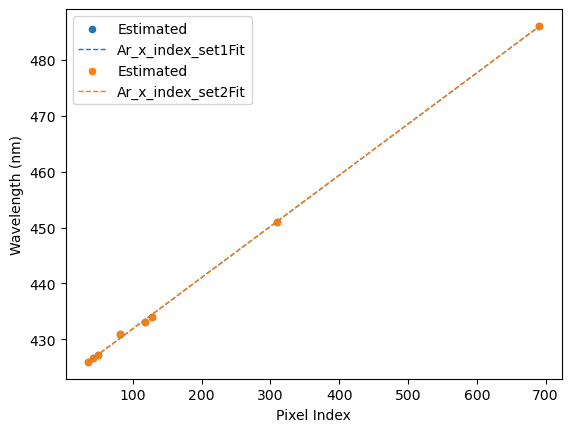

In [50]:
pix_vs_wavelength = pd.read_csv('Ar_pixels_vs_wavelength.csv').dropna()
print(pix_vs_wavelength.columns)
pix_vs_wavelength['Ar_x_index_set1'] = pix_vs_wavelength['x_pixel'] - 1.5 
pix_vs_wavelength['Ar_x_index_set2'] = pix_vs_wavelength['Ar_x_index_set1'].copy()
uncertainty = np.ones(len(pix_vs_wavelength['Ar_x_index_set1']))

print(pix_vs_wavelength)
indices = ['Ar_x_index_set1', 'Ar_x_index_set2']
wavelengths = pix_vs_wavelength['wavelength']
for index in indices:
    x_index = pix_vs_wavelength[index]
    slope, intercept = np.polyfit(x_index, wavelengths, 1)
    calibration_stats[index] = [slope, intercept]
    plt.scatter(x_index, wavelengths, marker='o', s=20, label='Estimated')
    plt.plot(x_index, pixel_to_wavelength_index(x_index, slope, intercept), ls='--', lw=1.0, label=index+'Fit')
    #plt.errorbar(x_index, pixel_to_wavelength_index(x_index, slope, intercept), ls='--', lw=1.0, label=index+'Fit')
    plt.ylabel('Wavelength (nm)')
    plt.xlabel('Pixel Index')
    #plt.yticks(np.arange(590,671,10))
    #plt.xticks(np.arange(40,600,50))
    plt.legend()
    print(f'{index}==> Slope: {slope:.3f}, Intercept: {intercept:.3f}')

## Science (Target Spectra) Gaussian Cutting
The idea here is, column by column: 
1) Find the mean and standard deviation 
2) Define a cut that selects data points that are above/within a certain threshold range. These data points correspond to the signal from our target, which are the high signal pixels.
3) Move all data points that fall outside of this range into a new background array.
4) Find the mean and standard deviation of this array and remove any outliers.
5) The final signal will be calcualted as follows: \
$\Large{S' = S - N\mu_{background}}$,\
where N is the number of pixels in the signal array.

##### Signal and Background

In [53]:
def histograms_bkg(data,range1,range2,ylim=()):
    plt.figure(figsize=(10,3))
    plt.hist(data.flatten(),bins=50, range=range1, alpha=.8, color='red',label='3stds')
    plt.hist(data.flatten(),bins=50, range=range2, alpha=.5, color='blue',label='max')
    plt.title('background counts - does not show all')
    plt.grid(True)
    plt.legend()
    if ylim != ():
        plt.ylim(ylim)

mean(means1)=15.113, mean(means1)=514.527, mean(stds1)=1079.201
mean(medians2)=1651.923, mean(means2)=1871.436, mean(stds2)=1341.354
mean(mediansbkg)=12.152, mean(meansbkg)=30.974, mean(stdsbkg)=13.384, max=613.0442804722232

mean(mean_background)=30.974, mean(stds_background)=67.944

mean(means1)=13.263, mean(means1)=630.461, mean(stds1)=1380.310
mean(medians2)=2883.489, mean(means2)=2522.680, mean(stds2)=1730.319
mean(mediansbkg)=10.291, mean(meansbkg)=38.494, mean(stdsbkg)=26.925, max=1070.96907436717

mean(mean_background)=38.494, mean(stds_background)=97.515

mean(means1)=16.428, mean(means1)=1061.324, mean(stds1)=2980.026
mean(medians2)=2100.929, mean(means2)=4332.403, mean(stds2)=4748.179
mean(mediansbkg)=11.727, mean(meansbkg)=17.776, mean(stdsbkg)=120.422, max=21732.752499215832

mean(mean_background)=17.776, mean(stds_background)=26.045

mean(means1)=14.885, mean(means1)=1136.142, mean(stds1)=3209.737
mean(medians2)=2034.909, mean(means2)=4524.165, mean(stds2)=5111.043
mean(m

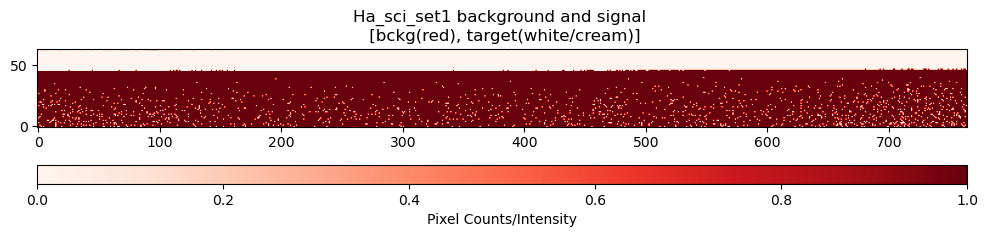

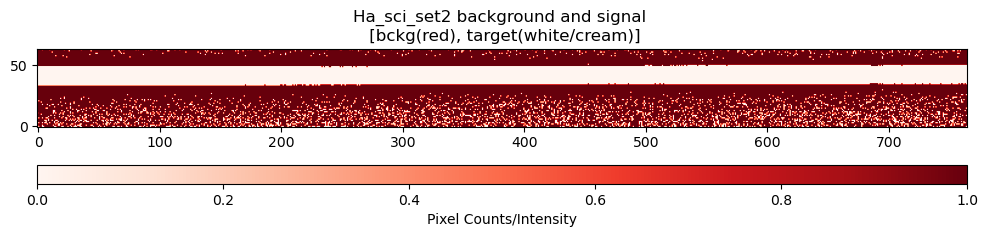

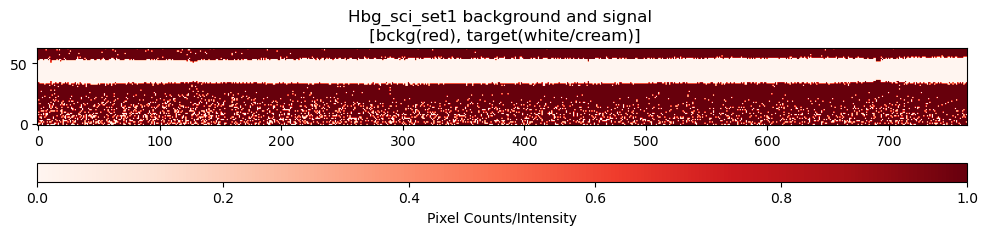

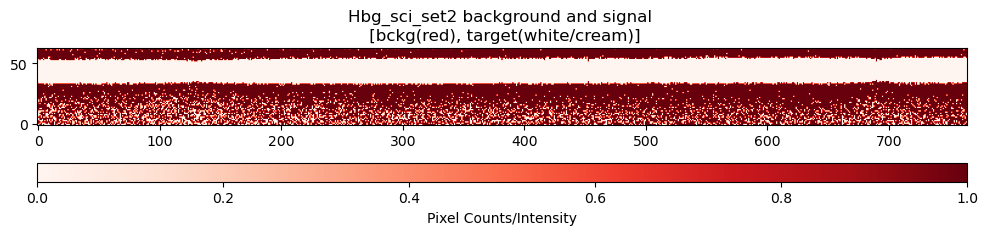

In [54]:
target_signal = {key: [] for key in calibrated_science.keys()}
target_signal_unc = {key: [] for key in calibrated_science.keys()}
background_signal = {key: [] for key in calibrated_science.keys()}
background_signal_unc = {key: [] for key in calibrated_science.keys()}

for (key,value), (ukey,uvalue), (tkey,tvalue) in zip(calibrated_science.items(), calibrated_science_unc.items(), target_signal.items()):
    #Look at statistics of data
    medians = np.median(value, axis=0)
    means = np.mean(value, axis=0)
    stds = np.std(value, axis=0)
    print(f"mean(means1)={np.mean(medians):.3f}, mean(means1)={np.mean(means):.3f}, mean(stds1)={np.mean(stds):.3f}")
    
    #Need to look at data above initial background threshold (median)
    initial_cut = medians + 100
    initial_mask = value > initial_cut
    data_cut = np.where(initial_mask, value, np.nan)
    data_unc_cut = np.where(initial_mask, uvalue, np.nan)
    medians = np.nanmedian(data_cut, axis=0)
    means = np.nanmean(data_cut, axis=0)
    stds = np.nanstd(data_cut, axis=0)
    print(f"mean(medians2)={np.mean(medians):.3f}, mean(means2)={np.mean(means):.3f}, mean(stds2)={np.mean(stds):.3f}")
    
    #Define Second Cut on Target
    target_min = means - stds #1
    target_max = means + 3*stds #3
    target_mask = (data_cut >= target_min) & (data_cut <= target_max)
    filtered_data = np.where(target_mask, data_cut, np.nan)
    filtered_data_unc = np.where(target_mask, data_unc_cut, np.nan)
    #Save to dict
    target_signal[key] = filtered_data
    target_signal_unc[key] = filtered_data_unc
    #print(filtered_data, '\n\n\n\n', filtered_data_unc)
    
    #Background Data
    bkg_mask_nan = np.isnan(filtered_data)
    background = np.where(bkg_mask_nan, value, np.nan) 
    background_unc = np.where(bkg_mask_nan, uvalue, np.nan) 
    background = np.where(background == 0, np.nan, background)
    # display_cut_spectrum(np.where(bkg_mask_nan, 1, 0),
    #    title=key+' background and signal \n [bckg(red), target(white/cream)]', cmap='Reds')
    # display_cut_spectrum(np.where(bkg_mask_nan, value, 0),
    #    title=key+' background and signal actual values \n [bckg(red), target(white/cream)]', cmap='Reds')
    
    #Background Statistics
    medians = np.nanmedian(background, axis=0)
    means = np.nanmean(background, axis=0)
    stds = np.nanstd(background, axis=0)
    maximum = np.max(np.where(np.isnan(background), 0, background))
    mu=np.mean(means)
    sig=np.std(stds)
    print(f"mean(mediansbkg)={np.mean(medians):.3f}, mean(meansbkg)={mu:.3f}, mean(stdsbkg)={sig:.3f}, max={maximum}",end='\n\n')
    #histograms_bkg(background, range1=[mu-sig,mu+3*sig], range2=[-10,maximum], ylim=(0,1000))

    #Now define a cut on the background to remove excess noise
    bkg_min = 0
    bkg_max = means + 1*stds #1
    bkg_mask = (background > bkg_min) & (background <= bkg_max)
    background_signal[key] = np.where(bkg_mask, background, np.nan)
    background_signal_unc[key] = np.where(bkg_mask, background_unc, np.nan)
    means = np.nanmean(background, axis=0)
    stds = np.nanstd(background, axis=0)
    print(f"mean(mean_background)={np.mean(means):.3f}, mean(stds_background)={np.mean(stds):.3f}",end='\n\n')
    display_cut_spectrum(np.where(bkg_mask, 1, 0),        
            title=key+' background and signal \n [bckg(red), target(white/cream)]', cmap='Reds')

##### Adjusted Signal

In [56]:
def weighted_mean(data,uncertainties,axis):
    uncertainties = np.nan_to_num(uncertainties, nan=np.inf)
    # Weights
    weights = 1 / uncertainties**2
    # Weighted Mean
    weighted_mean = np.nansum(data * weights, axis=axis) / np.nansum(weights, axis=axis)
    # Uncertianty in Mean
    uncertainty_mean = np.sqrt(1 / np.nansum(weights, axis=axis))
    return weighted_mean, uncertainty_mean

In [57]:
finalized_science = {key: [] for key in calibrated_science.keys()}
finalized_science_unc = {key: [] for key in calibrated_science.keys()}

for (key,value), (ukey,uvalue), (bkey, bvalue), (ubkey, ubvalue) in zip(target_signal.items(), 
                 target_signal_unc.items(), background_signal.items(), background_signal_unc.items()):
    #print(key,ukey,bkey,ubkey)'
    
    # Calculate S'
    target_sum = np.nansum(value, axis=0)  
    target_pixels = np.sum(~np.isnan(value), axis=0) # Number of target pixels per column
    #print(target_pixels)
    background_mean = weighted_mean(bvalue, ubvalue, axis=0)[0] # mean of each column
    #print(background_mean)
    finalized_science[key] = target_sum - (target_pixels*background_mean)
    
    # Calculate uncertainties
    target_sum_unc = quadrature_unc(uvalue, axis=0)
    #print(np.nansum(target_sum_unc))
    background_mean_unc = weighted_mean(bvalue, ubvalue, axis=0)[1]
    #print(np.nansum(background_mean_unc))
    finalized_science_unc[key] = darks_correction_uncertianty(target_sum_unc, target_pixels*background_mean_unc)

##### Initial Check

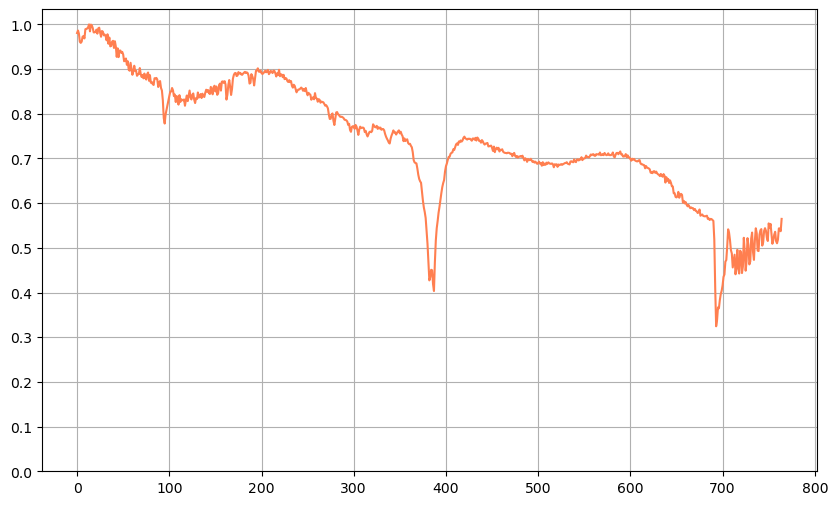

In [59]:
#Target not background subtracted
plot = True
data = target_signal['Ha_sci_set1']
data_unc = target_signal_unc['Ha_sci_set1']

y = normalize_to_unity(data, array_uncert=data_unc, return_uncert=False)
yerror = normalize_to_unity(data, array_uncert=data_unc, return_uncert=True)
x = np.arange(len(y))
if plot:
    plt.figure(figsize=(10,6))
    plt.plot(x,y, color='coral')
    plt.yticks(np.arange(0,1.1,.1))
    #plt.errorbar(x,y,yerr=yerror, fmt='.',color='coral', alpha=.6)
    #plt.xlim(370,400)
    #plt.ylim(.2,.5)
    #plt.xlim(685,710)
    #plt.ylim(.45,.9)
    plt.grid(True)

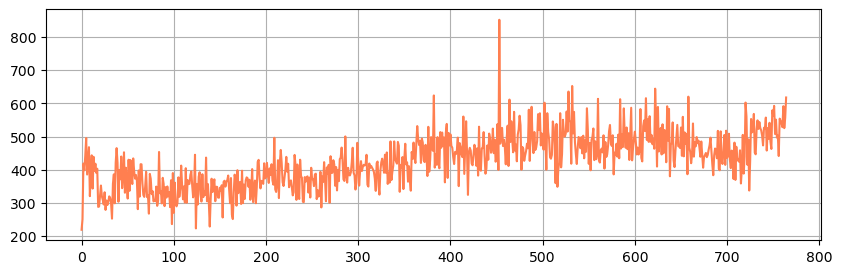

In [60]:
plot = True
ploterr = False
data = background_signal['Hbg_sci_set2']
data_unc = background_signal_unc['Hbg_sci_set2']
y = np.nansum(data, axis=0)
yerror = np.sqrt(np.nansum(np.square(data_unc), axis=0))
x = np.arange(len(y))
if plot:
    plt.figure(figsize=(10,3))
    plt.plot(x,y, color='coral')
    if ploterr: plt.errorbar(x,y,yerr=yerror, fmt='.',color='coral', alpha=.6)
    #plt.xlim(370,400)
    #plt.xlim(685,710)
    #plt.ylim(.2,.5)
    #plt.ylim(.45,.9)
    plt.grid(True)

If you see a dip in the background that might mean we dont have all the signal. If there is a spike maybe it is emission

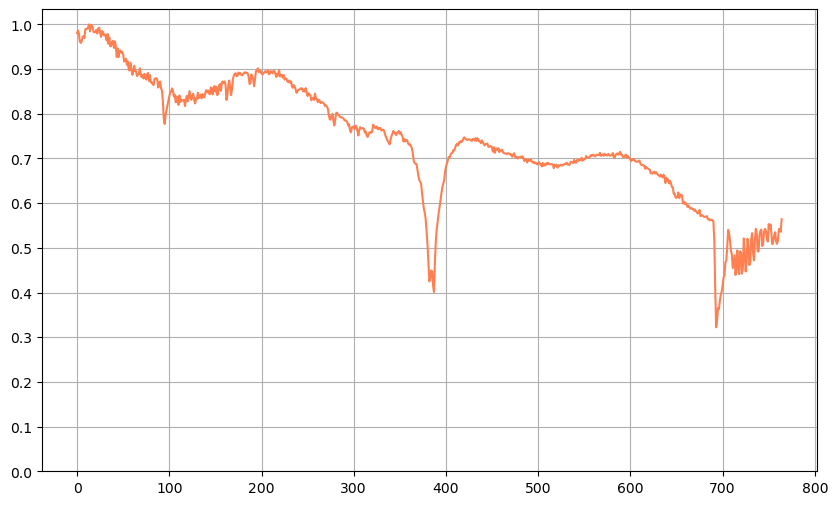

In [62]:
data = finalized_science['Ha_sci_set1']
data_unc = finalized_science_unc['Ha_sci_set1']

y = normalize_to_unity_1d(data, data_unc)[0]
yerror = normalize_to_unity_1d(data, data_unc)[1]
x = np.arange(len(y))

plt.figure(figsize=(10,6))
plt.plot(x,y, color='coral')
plt.yticks(np.arange(0,1.1,.1))
#plt.errorbar(x,y,yerr=yerror, fmt='.',color='coral', alpha=.6)
#plt.xlim(370,400)
#plt.ylim(.2,.5)
#plt.xlim(685,710)
#plt.ylim(.45,.9)
plt.grid(True)

## Plot Calibrated Spectrum and Science Spectra

##### key initialization

In [65]:
for key in calibration_stats.items(): print(key)

('Ne_x_index_set1', [0.0985549447494856, 618.9369313375619])
('Ne_x_index_set2', [0.09872051184568538, 619.0548025886893])
('Ar_x_index_set1', [0.09165163100599688, 422.71079947668056])
('Ar_x_index_set2', [0.09165163100599688, 422.71079947668056])


In [66]:
##### Normalize Spectra to be capped at 1 (for visualizing separately)
'''normalized_spectra = {'Ne_set1' : normalize_to_unity(calibrated_spectra['Ne_spect_set1'], ctype='median'),
                      'Ne_set2' : normalize_to_unity(calibrated_spectra['Ne_spect_set2'], ctype='median'),
                      'Ha_set1' : normalize_to_unity(calibrated_science['Ha_sci_set1'], ctype='sum'),
                      'Ha_set2' : normalize_to_unity(calibrated_science['Ha_sci_set2'], ctype='sum'),
                      'Ar_set1' : normalize_to_unity(calibrated_spectra['Ar_spect_set1'], ctype='median'),
                      'Ar_set2' : normalize_to_unity(calibrated_spectra['Ar_spect_set2'], ctype='median'),
                      'Hbg_set1' : normalize_to_unity(calibrated_science['Hbg_sci_set1'], ctype='sum'),
                      'Hbg_set2' : normalize_to_unity(calibrated_science['Hbg_sci_set2'], ctype='sum'),
                     }
'''
normalized_spectra = {'Ne_set1' : normalize_to_unity(calibrated_spectra['Ne_spect_set1'], ctype='median'),
                      'Ne_set2' : normalize_to_unity(calibrated_spectra['Ne_spect_set2'], ctype='median'),
                      'Ha_set1' : normalize_to_unity_1d(finalized_science['Ha_sci_set1'], finalized_science_unc['Ha_sci_set1'])[0],
                      'Ha_set2' : normalize_to_unity_1d(finalized_science['Ha_sci_set2'], finalized_science_unc['Ha_sci_set2'])[0],
                      'Ar_set1' : normalize_to_unity(calibrated_spectra['Ar_spect_set1'], ctype='median'),
                      'Ar_set2' : normalize_to_unity(calibrated_spectra['Ar_spect_set2'], ctype='median'),
                      'Hbg_set1' : normalize_to_unity_1d(finalized_science['Hbg_sci_set1'], finalized_science_unc['Hbg_sci_set1'])[0],
                      'Hbg_set2' : normalize_to_unity_1d(finalized_science['Hbg_sci_set2'], finalized_science_unc['Hbg_sci_set2'])[0],
                     }
'''normalized_spectra_unc = {'Ne_set1' : normalize_to_unity(calibrated_spectra['Ne_spect_set1'], ctype='median', return_uncert=True, 
                                      array_uncert=calibrated_spectra_unc['Ne_spect_set1']),
                          'Ne_set2' : normalize_to_unity(calibrated_spectra['Ne_spect_set2'], ctype='median', return_uncert=True, 
                                      array_uncert=calibrated_spectra_unc['Ne_spect_set2']),
                          'Ha_set1' : normalize_to_unity(calibrated_science['Ha_sci_set1'], ctype='sum', return_uncert=True, 
                                      array_uncert=calibrated_science_unc['Ha_sci_set1']),
                          'Ha_set2' : normalize_to_unity(calibrated_science['Ha_sci_set2'], ctype='sum', return_uncert=True, 
                                      array_uncert=calibrated_science_unc['Ha_sci_set2']),
                          'Ar_set1' : normalize_to_unity(calibrated_spectra['Ar_spect_set1'], ctype='median', return_uncert=True, 
                                      array_uncert=calibrated_spectra_unc['Ar_spect_set1']),
                          'Ar_set2' : normalize_to_unity(calibrated_spectra['Ar_spect_set2'], ctype='median', return_uncert=True, 
                                      array_uncert=calibrated_spectra_unc['Ar_spect_set2']),
                          'Hbg_set1' : normalize_to_unity(calibrated_science['Hbg_sci_set1'], ctype='sum', return_uncert=True, 
                                       array_uncert=calibrated_science_unc['Hbg_sci_set1']),
                          'Hbg_set2' : normalize_to_unity(calibrated_science['Hbg_sci_set2'], ctype='sum', return_uncert=True, 
                                       array_uncert=calibrated_science_unc['Hbg_sci_set2']),
                          }
'''
normalized_spectra_unc = {'Ne_set1' : normalize_to_unity(calibrated_spectra['Ne_spect_set1'], ctype='median', return_uncert=True, 
                                      array_uncert=calibrated_spectra_unc['Ne_spect_set1']),
                          'Ne_set2' : normalize_to_unity(calibrated_spectra['Ne_spect_set2'], ctype='median', return_uncert=True, 
                                      array_uncert=calibrated_spectra_unc['Ne_spect_set2']),
                          'Ha_set1' : normalize_to_unity_1d(finalized_science['Ha_sci_set1'], finalized_science_unc['Ha_sci_set1'])[1],
                          'Ha_set2' : normalize_to_unity_1d(finalized_science['Ha_sci_set2'], finalized_science_unc['Ha_sci_set2'])[1],
                          'Ar_set1' : normalize_to_unity(calibrated_spectra['Ar_spect_set1'], ctype='median', return_uncert=True, 
                                      array_uncert=calibrated_spectra_unc['Ar_spect_set1']),
                          'Ar_set2' : normalize_to_unity(calibrated_spectra['Ar_spect_set2'], ctype='median', return_uncert=True, 
                                      array_uncert=calibrated_spectra_unc['Ar_spect_set2']),
                          'Hbg_set1' : normalize_to_unity_1d(finalized_science['Hbg_sci_set1'], finalized_science_unc['Hbg_sci_set1'])[1],
                          'Hbg_set2' : normalize_to_unity_1d(finalized_science['Hbg_sci_set2'], finalized_science_unc['Hbg_sci_set2'])[1],
                          }
calibration_indices = {'Ne_set1' : 'Ne_x_index_set1',
                      'Ne_set2' : 'Ne_x_index_set2',
                      'Ha_set1' : 'Ne_x_index_set1',
                      'Ha_set2' : 'Ne_x_index_set2',
                      'Ar_set1' : 'Ar_x_index_set1',
                      'Ar_set2' : 'Ar_x_index_set2',
                      'Hbg_set1' : 'Ar_x_index_set1',
                      'Hbg_set2' : 'Ar_x_index_set2',
                     }

#### Single Plot
All you have to do is change the "spectrum_label" and you can also decide if you want to plot the error bars. 

In [195]:
for spectrum_label,index_set in calibration_indices.items():
    print(f"Label: {spectrum_label}")

Label: Ne_set1
Label: Ne_set2
Label: Ha_set1
Label: Ha_set2
Label: Ar_set1
Label: Ar_set2
Label: Hbg_set1
Label: Hbg_set2


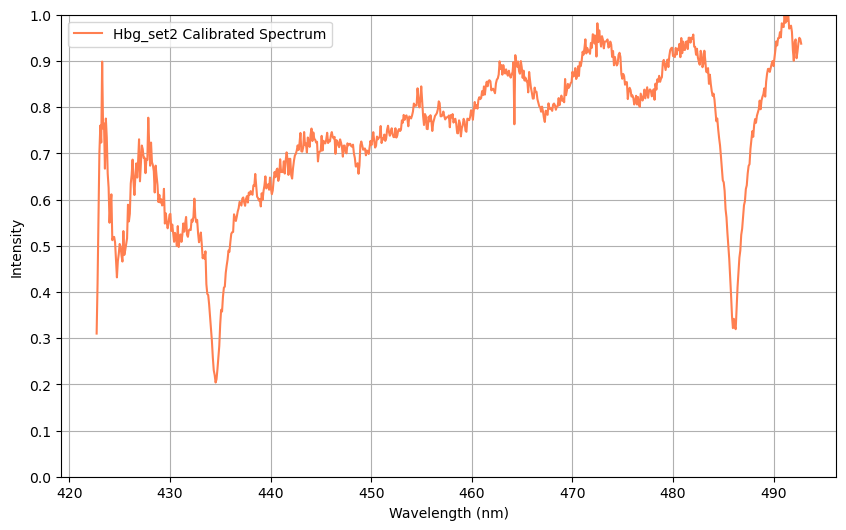

In [68]:
spectrum_label = 'Hbg_set2'
plt_error=False

index_set = calibration_indices[spectrum_label]
spectrum_index = np.arange(len(normalized_spectra[spectrum_label])) #pixel index
spectrum_wavelength_index = pixel_to_wavelength_index(spectrum_index, *calibration_stats[index_set]) #pixel index --> wavelength index
'''
#Find Peaks
peaks, _ = find_peaks(normalized_spectra[spectrum_label], height=(0.0,.4))  # Customize height threshold if needed
#print(peaks)
for peak in peaks:
    plt.annotate(f'{spectrum_wavelength_index[peak]:.1f} nm', 
                 (spectrum_wavelength_index[peak], normalized_spectra[spectrum_label][peak]), 
                 xytext=(0, 4), textcoords='offset points', ha='center', fontsize=7, color='red')
#'''
color = 'coral'
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(spectrum_wavelength_index, normalized_spectra[spectrum_label], label=spectrum_label+' Calibrated Spectrum', ms=5, c=color)
if plt_error:
    ax.errorbar(spectrum_wavelength_index, normalized_spectra[spectrum_label], yerr=normalized_spectra_unc[spectrum_label], 
                 fmt='.', c=color, label=spectrum_label+' Uncertainty', alpha=.5)
ax.set_ylabel('Intensity')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylim(0.0,1.0)
ax.set_yticks(ticks=np.arange(0.0,1.1,0.1))
#ax.set_xlim(np.min(spectrum_wavelength_index), np.max(spectrum_wavelength_index))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=150))
#ax.set_xticks(ticks=np.arange(np.min(spectrum_wavelength_index), np.max(spectrum_wavelength_index),5))#(ax.get_xticks())
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.xlim(600,680)

#Zoom in to a regiOn
#alpha:
#ax.set_xlim(655.5, 658)
#ax.set_ylim(0.38,0.7)
#beta:
#plt.xlim(484,488)
#plt.ylim(0.02,0.11)
#gamma:
#plt.xlim(433,436)
#plt.ylim(0.05,0.30)

#ax.set_xlim(490,500)
#ax.set_ylim(.00,.2)

#ax.set_xlim(686,688)
#ax.set_ylim(.4,.9)

#Plot Balmer Lines:
#plt.vlines(x=656.3, ymin=0, ymax=1, color='r')
#plt.vlines(x=486.1, ymin=0, ymax=1, color='cyan')
#plt.vlines(x=434, ymin=0, ymax=1, color='blue')

plt.legend()
plt.grid(True)

#### Stacked Plots

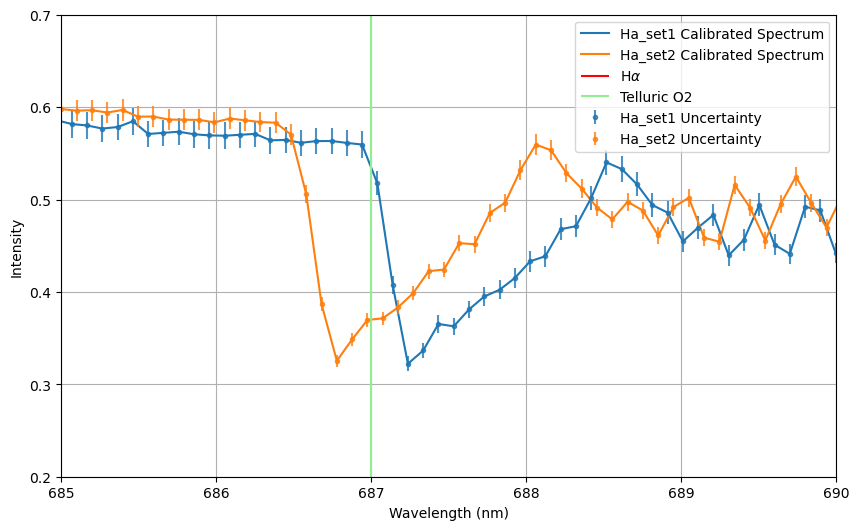

In [70]:
#View Stacked Spectra
plot_error = True
spectrum_labels = ['Ha_set1','Ha_set2'] #['Ha_set1','Ha_set2','Hbg_set1', 'Hbg_set2'] 
index_sets=[]
for i in range(len(spectrum_labels)):
    index_sets.append(calibration_indices[spectrum_labels[i]])
fig, ax = plt.subplots(figsize=(10,6))
for (s_label, i_set) in zip(spectrum_labels, index_sets):
    spectrum_index = np.arange(len(normalized_spectra[s_label]))
    spectrum_wavelength_index = pixel_to_wavelength_index(spectrum_index, *calibration_stats[i_set])
    line, = ax.plot(spectrum_wavelength_index, normalized_spectra[s_label], label=s_label+' Calibrated Spectrum')
    line_color = line.get_color()
    if plot_error:
        ax.errorbar(spectrum_wavelength_index, normalized_spectra[s_label], normalized_spectra_unc[s_label], 
                fmt='.', label=s_label+' Uncertainty', color=line_color, alpha=.8)
'''
#Find Peaks
peaks, _ = find_peaks(normalized_spectra[spectrum_label], height=(0,.35))  # Customize height threshold if needed
#print(peaks)
for peak in peaks:
    plt.annotate(f'{spectrum_wavelength_index[peak]:.1f} nm', 
                 (spectrum_wavelength_index[peak], normalized_spectra[spectrum_label][peak]), 
                 xytext=(0, 4), textcoords='offset points', ha='center', fontsize=7, color='red')
'''

plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.yticks(np.arange(0.0,1.1,0.1))
#plt.xticks(np.arange(420,500,5),rotation=90)
#plt.xticks(np.arange(420,500,5),rotation=90)

#Zoom in to a regiOn
#alpha:
#ax.set_xlim(655.5, 658)
#ax.set_ylim(0.25,0.55)
#beta:
#plt.xlim(484,488)
#plt.ylim(0.3,0.9)
#gamma:
#plt.xlim(433,436.5)
#plt.ylim(0.05,0.7)
#O2:
plt.xlim(685,690)
plt.ylim(0.2,0.7)

#Plot Balmer Lines:
plt.vlines(x=656.3, ymin=0, ymax=1, color='r', label='H$\\alpha$')
#plt.vlines(x=486.1, ymin=0, ymax=1, color='cyan', label='H$\\beta$')
#plt.vlines(x=434, ymin=0, ymax=1, color='blue', label='H$\\gamma$')
plt.vlines(x=687, ymin=0, ymax=1, color='lightgreen', label='Telluric O2')

plt.legend(loc='upper right')
plt.grid(True)

## Gaussian Fitting

In [72]:
def wavelength_to_pixel_index(wavelength, slope, b):
    return (wavelength - b) / slope
def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu)**2) / (2 * sigma**2))
def double_gaussian(wavelength, A1, mu1, sigma1, A2, mu2, sigma2):
    return (
        A1 * np.exp(-(wavelength - mu1) ** 2 / (2 * sigma1 ** 2)) +
        A2 * np.exp(-(wavelength - mu2) ** 2 / (2 * sigma2 ** 2))
    )
def doppler_shift_function(mu1, mu2, lambda_rest):
    '''
    Rest Wavelength in nm
    mu1 and mu2 in nm
    returns in km/s
    '''
    c = 3e8
    delta_lambda = (mu2 - mu1)
    return (c * delta_lambda) / (lambda_rest * 1e3)

##### Choose Spectrum

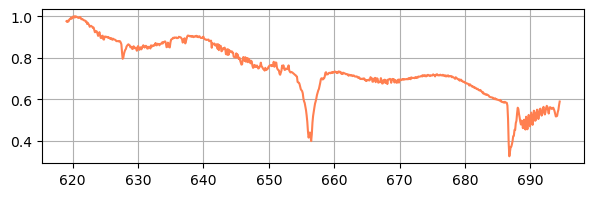

In [74]:
spectrum_label = 'Ha_set2'
index_set = calibration_indices[spectrum_label]
spectrum_index = np.arange(len(normalized_spectra[spectrum_label])) #pixel index
spectrum_wavelength_index = pixel_to_wavelength_index(spectrum_index, *calibration_stats[index_set]) #pixel index --> wavelength index
plt.figure(figsize=(7, 2))
plt.plot(spectrum_wavelength_index, normalized_spectra[spectrum_label], label=spectrum_label+' Calibrated Spectrum', ms=5, c=color)
plt.grid(True)

##### Set Mask and Intensity Offset
Select the wavelength range with the mask, and set the offset so that the base of the gaussian is around zero.

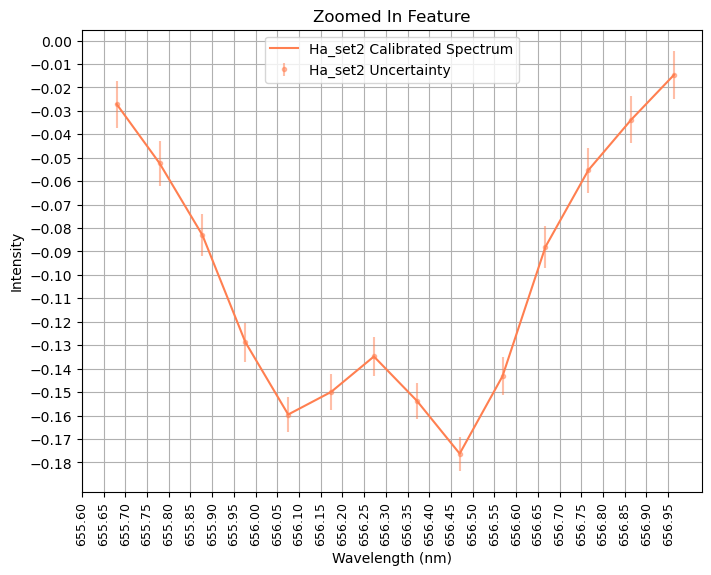

In [76]:
wavelength_mask = [655.6,657] #x0 to xn
offset = -0.54 + .14 -.175 # adjust until the base of the gaussian is around 0.0

mask = (spectrum_wavelength_index >= wavelength_mask[0]) & (spectrum_wavelength_index <= wavelength_mask[1])
wavelengths = spectrum_wavelength_index[mask]
spectrum = normalized_spectra[spectrum_label][mask] + offset
spectrum_unc = normalized_spectra_unc[spectrum_label][mask]

plt.figure(figsize=(8, 6))
color = 'coral'
plt.plot(wavelengths, spectrum, label=spectrum_label+' Calibrated Spectrum', ms=5, c=color)
plt.errorbar(wavelengths, spectrum, yerr=spectrum_unc, 
            fmt='.', c=color, label=spectrum_label+' Uncertainty', alpha=.5)
plt.title('Zoomed In Feature')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.xticks(np.arange(655.6,657,0.05), rotation=90, size=9)
plt.yticks(np.arange(-0.18,0.01,.01))
plt.grid(True)
plt.legend(loc='upper center')

#### Plot of Double Gaussian Fit
Make good initial guesses by looking at the plot above.

Fitted Parameters:
Peak 1: A1 = -0.14, mu1 = 656.05, sigma1 = 0.18
Peak 2: A2 = -0.16, mu2 = 656.49, sigma2 = 0.18

Doppler Shift: 201.53 km/s 



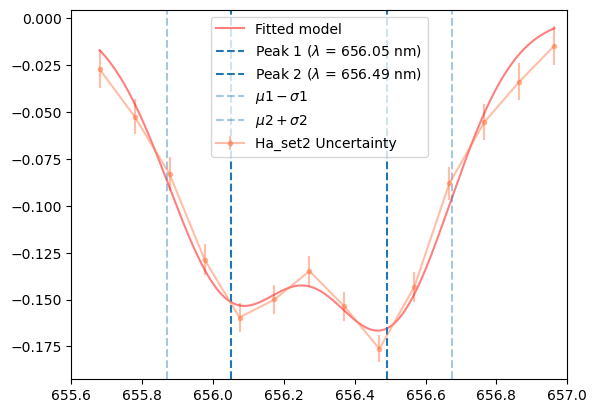

In [169]:
# Initial guesses for fitting (A1, mu1, sigma1, A2, ...)
#initial_guess = [-0.26, 656.6, 0.1, -0.25, 657.1, 0.2]
#initial_guess = [-0.24, 656.1, 0.1, -0.26, 656.4, 0.1]
initial_guess = [-0.16, 656.05, 0.2, -0.175, 656.456, 0.2]

# Fit the double Gaussian model to the data
popt, pcov = curve_fit(double_gaussian, wavelengths, spectrum, p0=initial_guess,
                      sigma=spectrum_unc, absolute_sigma=True)

# Extract the fitted parameters
A1_fit, mu1_fit, sigma1_fit, A2_fit, mu2_fit, sigma2_fit = popt

# Plot the results
#plt.plot(wavelengths, spectrum, label=spectrum_label+' Calibrated Spectrum', ms=5, c=color)
plt.errorbar(wavelengths, spectrum, yerr=spectrum_unc, ls='-',
            fmt='.', c=color, label=spectrum_label+' Uncertainty', alpha=.5)
xrange = np.linspace(np.min(wavelengths), np.max(wavelengths), 10000)
plt.plot(xrange, double_gaussian(xrange, *popt), 'r-', label='Fitted model', alpha=.5)
plt.axvline(mu1_fit, linestyle='--', label=f'Peak 1 ($\lambda$ = {mu1_fit:.2f} nm)')
plt.axvline(mu2_fit, linestyle='--', label=f'Peak 2 ($\lambda$ = {mu2_fit:.2f} nm)')
plt.axvline(mu1_fit-sigma1_fit, linestyle='--', label=f'$\mu1 - \sigma1$',alpha=.4)
plt.axvline(mu2_fit+sigma2_fit, linestyle='--', label=f'$\mu2 + \sigma2$',alpha=.4)
#plt.xticks(np.arange(653,661,0.25), rotation=90, size=8)
plt.xlim(wavelength_mask)
plt.legend()
print(f"Fitted Parameters:")
print(f"Peak 1: A1 = {A1_fit:.2f}, mu1 = {mu1_fit:.2f}, sigma1 = {sigma1_fit:.2f}")
print(f"Peak 2: A2 = {A2_fit:.2f}, mu2 = {mu2_fit:.2f}, sigma2 = {sigma2_fit:.2f}")
print(f"\nDoppler Shift: {doppler_shift_function(mu1_fit, mu2_fit, lambda_rest=656.3):.2f} km/s \n")

### Chi Squared and Residuals

In [158]:
residuals = spectrum - double_gaussian(wavelengths, *popt)
chi_squared = np.sum((residuals / spectrum_unc)**2)
nu = (len(wavelengths) - len(popt))
reduced_chi_square = chi_squared / nu
p_value = 1 - chi2.cdf(chi_squared, nu)
print(f"Chi-Square: {chi_squared:.2f}")
print(f"Reduced chi-square: {reduced_chi_square:.2f}")
print(f"P-Value: {p_value:.2f}")

Chi-Square: 11.43
Reduced chi-square: 1.43
P-Value: 0.18


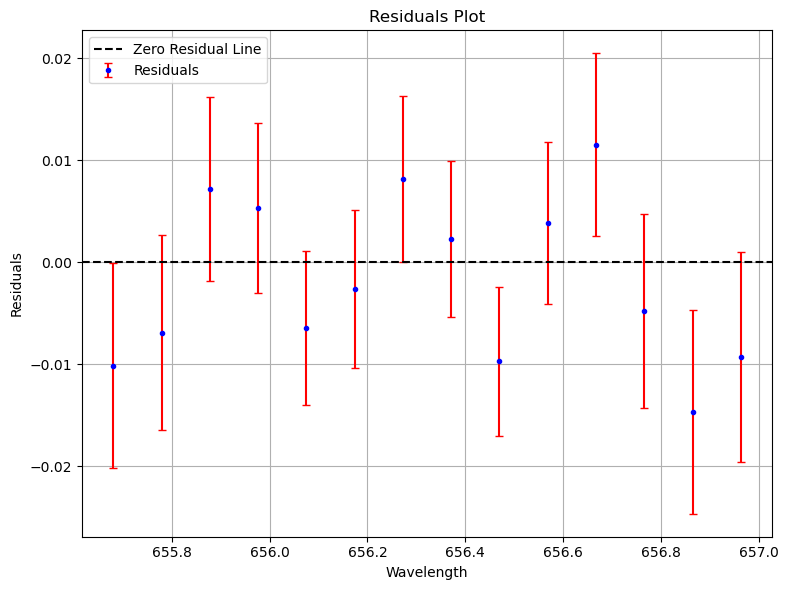

In [161]:
plt.figure(figsize=(8, 6))
plt.errorbar(wavelengths, residuals, yerr=spectrum_unc, fmt='.', label='Residuals', color='blue', ecolor='red', capsize=3)
plt.axhline(0, color='black', linestyle='--', label='Zero Residual Line')
plt.xlabel('Wavelength')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Monte Carlo

C:\Users\antho\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Iterations Ran: 200
Mean Wavelength Shift: 0.422 nm
Uncertainty in Wavelength Shift: 0.051 nm
Mean Doppler Shift: 192.688 km/s
Uncertainty in Doppler Shift: 23.450 km/s


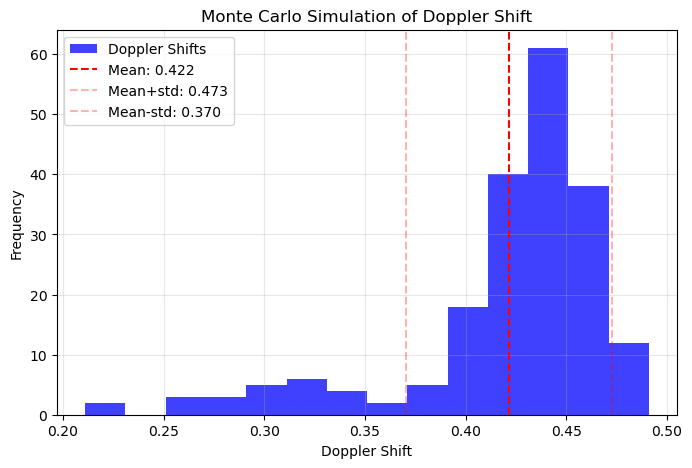

In [185]:
#Monte Carlo
np.random.seed(13) 
num_simulations = 200
doppler_shifts = []
wavelength_unc = np.full_like(wavelengths, 0.05)

for _ in range(num_simulations):
    try:
        #Perturbation
        perturbed_spectrum = spectrum + np.random.normal(0, spectrum_unc) 
        perturbed_wavelengths = wavelengths + np.random.normal(0, wavelength_unc)
        #Estimate Params
        popt, pcov = curve_fit(double_gaussian, perturbed_wavelengths, perturbed_spectrum, 
                               p0=initial_guess, sigma=spectrum_unc, absolute_sigma=True, maxfev=10000)
        #Find doppler shift
        doppler_shift = popt[4] - popt[1]
        doppler_shifts.append(doppler_shift)
    except Exception as e:
        print(f"Error during fit: {e}")
        continue  # Skip this iteration if the fit fails
print(f"Iterations Ran: {len(doppler_shifts)}")
# Calculate Results
doppler_shifts = np.array(doppler_shifts)
mean_shift = np.mean(doppler_shifts)
std_shift = np.std(doppler_shifts)
mean_doppler_shift_velocity = doppler_shift_function(mu2=mean_shift, mu1=0, lambda_rest=656.3)
mean_doppler_shift_uncertainty = doppler_shift_function(mu2=std_shift, mu1=0, lambda_rest=656.3)

print(f"Mean Wavelength Shift: {mean_shift:.3f} nm")
print(f"Uncertainty in Wavelength Shift: {std_shift:.3f} nm")
print(f"Mean Doppler Shift: {mean_doppler_shift_velocity:.3f} km/s")
print(f"Uncertainty in Doppler Shift: {mean_doppler_shift_uncertainty:.3f} km/s")

# Plot distribution of Doppler shifts
bins = np.arange(min(doppler_shifts), max(doppler_shifts), 0.02)  # Adjust bin width if necessary
plt.figure(figsize=(8, 5))
plt.hist(doppler_shifts, bins=bins, alpha=0.75, color='blue', label='Doppler Shifts')
plt.axvline(mean_shift, color='red', linestyle='--', label=f'Mean: {mean_shift:.3f}')
plt.axvline(mean_shift + std_shift, color='red', linestyle='--', label=f'Mean+std: {mean_shift + std_shift:.3f}', alpha=.3)
plt.axvline(mean_shift - std_shift, color='red', linestyle='--', label=f'Mean-std: {mean_shift - std_shift:.3f}', alpha=.3)
plt.xlabel('Doppler Shift')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation of Doppler Shift')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Radial Velocity Curve (Theoretical)

Radial Velocity Difference Between t1 and t2: 40.528 km/s 
Time Duration: 3.000 hrs
v(t=t1)=57.240 km/s 
v(t=t2)=97.768 km/s
Pixel shift for v1: 1.252 angstroms(pixels)
Pixel shift for v2: 2.139 angstroms(pixels)
Expected velocity at time of observation (6.383 hrs): 199.787


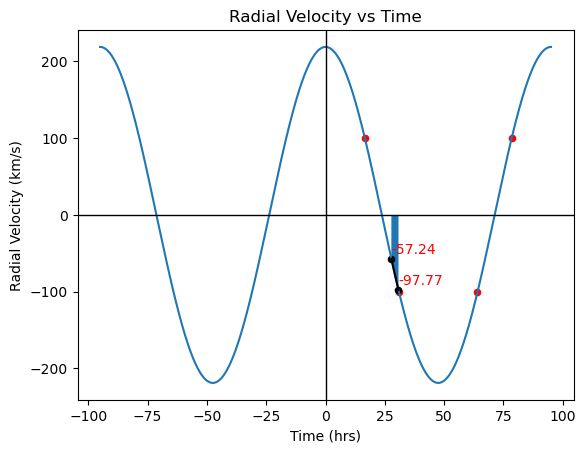

In [167]:
Period = 3.96004753 
Period_hrs = Period*24
def radial_velocity_curve(t):
    w = (np.pi*2) / Period_hrs
    A = 219
    return A*np.cos(w*t)
times = np.linspace(-Period_hrs,Period_hrs,10000)
plt.plot(times, radial_velocity_curve(times))
plt.axhline(y=0,c='black',lw=1)
plt.axvline(x=0,c='black',lw=1)

def wavelength_shift(wavelength, velocity):
    '''
    wavelength in nm
    velocity in km/s
    returns wavelength shift in angstroms
    '''
    wavelengths = {'alpha':656.3,
                   'beta':486.1,
                   'gamma':434.0}
    wavelength = wavelengths[wavelength]
    c = 3.0e8
    return ((1e-6*wavelength*velocity)/c) * 1e10

#delta1 = #-Period_hrs/2 + 61.5
#delta2 = #-Period_hrs/2 + 64

'''These are the times when the radial velocities 
reach the limit of what we can see on the spectrograph:'''
tmx1 = 16.5300020187
tmx2 = 30.9905683413
tmx3 = 64.0505723787
tmx4 = 78.5111387013
plt.scatter(x=tmx1, y=radial_velocity_curve(tmx1),c='red',s=20)
plt.scatter(x=tmx2, y=radial_velocity_curve(tmx2),c='red',s=20)
plt.scatter(x=tmx3, y=radial_velocity_curve(tmx3),c='red',s=20)
plt.scatter(x=tmx4, y=radial_velocity_curve(tmx4),c='red',s=20)

'''Here is for visualizing a theoretical start and end time.
Choose t1 and t2. The area under the graph between these two points 
will be filled in.
'''
#t1 = Period_hrs/4 + 4 + (16.0/60.0)
#t2 = Period_hrs/4 + 4 + (26.0/60.0)
t1 = Period_hrs/4 + 4
t2 = Period_hrs/4 + 7
#t1 = 4
#t2 = 8

tvalues=np.linspace(t1,t2,100)
plt.fill_between(tvalues,radial_velocity_curve(tvalues))
plt.plot(tvalues,radial_velocity_curve(tvalues),color='black')
plt.scatter(x=t1, y=radial_velocity_curve(t1),c='black',s=20)
plt.text(t1+.01,radial_velocity_curve(t1)+7,f'{radial_velocity_curve(t1):.2f}',size=10, c='r')
plt.scatter(x=t2, y=radial_velocity_curve(t2),c='black',s=20)
plt.text(t2+.01,radial_velocity_curve(t2)+7,f'{radial_velocity_curve(t2):.2f}',size=10, c='r')
print(f'Radial Velocity Difference Between t1 and t2: \
{(radial_velocity_curve(t1) - radial_velocity_curve(t2)):.3f} km/s \nTime Duration: {(t2-t1):.3f} hrs')
print(f'v(t=t1)={abs(radial_velocity_curve(t1)):.3f} km/s \nv(t=t2)={abs(radial_velocity_curve(t2)):.3f} km/s')
print(f"Pixel shift for v1: {wavelength_shift('alpha',abs(radial_velocity_curve(t1))):.3f} angstroms(pixels)")
print(f"Pixel shift for v2: {wavelength_shift('alpha',abs(radial_velocity_curve(t2))):.3f} angstroms(pixels)")

plt.xlabel('Time (hrs)')
plt.ylabel('Radial Velocity (km/s)')
plt.title('Radial Velocity vs Time')
plt.plot()

time_obs = 6 + 23/60
print(f"Expected velocity at time of observation ({time_obs:.3f} hrs): {radial_velocity_curve(time_obs):.3f}")